In [23]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
import pandas as pd
import numpy as np
import os

## Load data

In [27]:
data = pd.read_pickle('../data/data_proton_photonsum_30.pkl')
print('Loaded: ',  data.shape)
data_cond = pd.read_pickle('../data/data_cond_photonsum_30.pkl')
print('Loaded cond: ',  data_cond.shape)

Loaded:  (15892, 56, 30)
Loaded cond:  (15892, 12)


In [28]:
data_cond.drop(columns=['neutron_photon_sum', 'proton_photon_sum'], inplace=True)

In [29]:
data_cond.head()

Pdg   Energy   Vx   Vy   Vz        Px        Py       Pz        mass  \
0  2212  3961.55  0.0  0.0  0.0 -0.076487  0.179845  3961.55  938.272081   
1  2212  3195.12  0.0  0.0  0.0  0.560528 -0.149980  3195.11  938.272081   
2  2112  1714.07  0.0  0.0  0.0  0.457768  0.145639 -1714.07  939.565413   
3  2112  4583.24  0.0  0.0  0.0  0.573319 -0.017014 -4583.24  939.565413   
4   211  3294.80  0.0  0.0  0.0  0.116012  0.164051  3294.80  139.570610   

   charge  
0     1.0  
1     1.0  
2     0.0  
3     0.0  
4     1.0

### Preprocess data

In [30]:
data = np.float32(np.log(data+1))

In [31]:
# Credits: majerzemilia

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel_ as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.11.0


In [37]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "model_"+DATE_STR

EXPERIMENT_NAME = f"{DATE_STR}_MIN_30"

print(DATE_STR, NAME, EXPERIMENT_NAME)

02_03_2023_23_55 model_02_03_2023_23_55 02_03_2023_23_55_MIN_30


In [33]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)
    with open(f"../models/{out_fnm}", mode="w") as f:
        f.write(res)

In [34]:
#train/test split
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#scale cond data
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
print("cond max", y_train.max(), "min", y_train.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

# make tf datasets
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond)).shuffle(12800)

(12713, 56, 30) (3179, 56, 30) (12713, 10) (3179, 10)
cond max 36.832603322159116 min -29.166053416694734


In [35]:
############################ Define Models ############################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 10
cond_dim = 10
poz_dim = 6


############################ encoder ############################

input_img = Input(shape=[56,30,1],name='input_img')
input_cond = Input(shape=cond_dim,name='input_cond')
x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)
x = Conv2D(64, kernel_size=4, strides=2,padding='same')(x)
x = Conv2D(128, kernel_size=4, strides=2,padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = layers.concatenate([input_cond, x])
x = layers.Dense(latent_dim*2, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([input_img, input_cond], [z_mean, z_log_var, z], name="encoder")
encoder.summary()
############################ decoder ############################


x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

g = Dense(7*4*128)(inputs)
g = Reshape((7,4,128))(g)

g = UpSampling2D()(g)
g = Conv2D(128, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(64, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(32, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

outputs = Conv2D(1, kernel_size=(1,3) ,activation='relu')(g)

generator = Model([x, cond], outputs, name='generator')
generator.summary()


# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

# define optimizer
vae_optimizer = tf.keras.optimizers.RMSprop(1e-4)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 56, 30, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 28, 15, 32)   544         ['input_img[0][0]']              
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 8, 64)    32832       ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 7, 4, 128)    131200      ['conv2d_8[0][0]']               
                                                                                            

In [38]:
#trainin params

EPOCHS = 101
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[:num_examples_to_generate]


### function to calculate ws distance between orginal and generated channels
org=np.exp(x_test)-1
ch_org = org.reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org

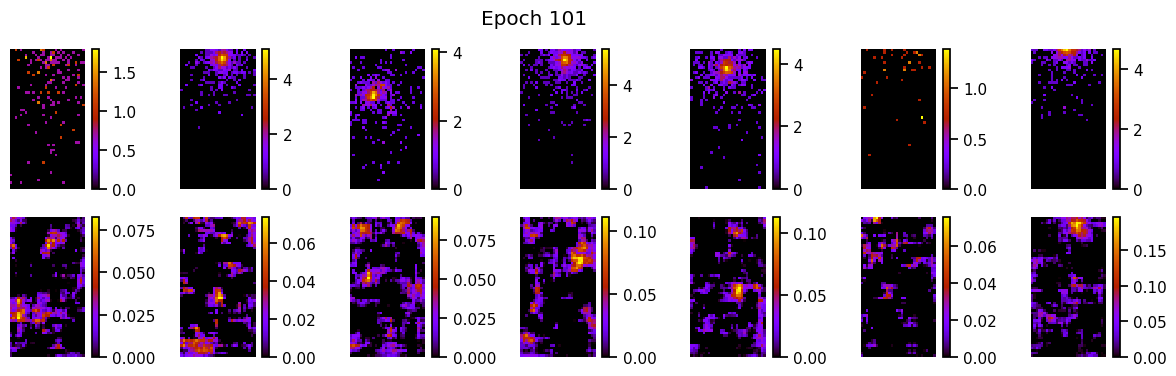

100 [Total loss: 85.69] [Recon_loss: 83.61] [KL loss: 2.97]


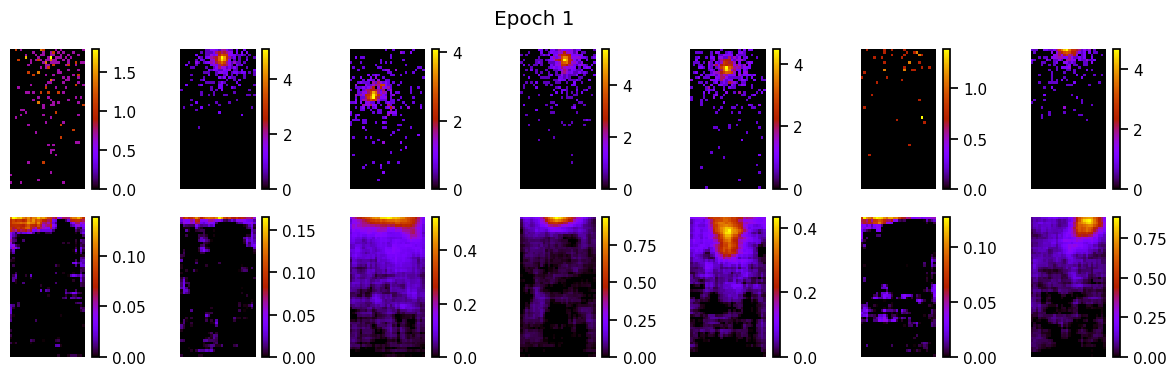

100/100 [==============================] - 0s 4ms/step
ws mean 56.57 ch1 39.03 ch2 99.51 ch3 0.55 ch4 0.65 ch5 143.09 Time for epoch 1 is 10.082569122314453 sec
200 [Total loss: 63.69] [Recon_loss: 60.87] [KL loss: 4.02]


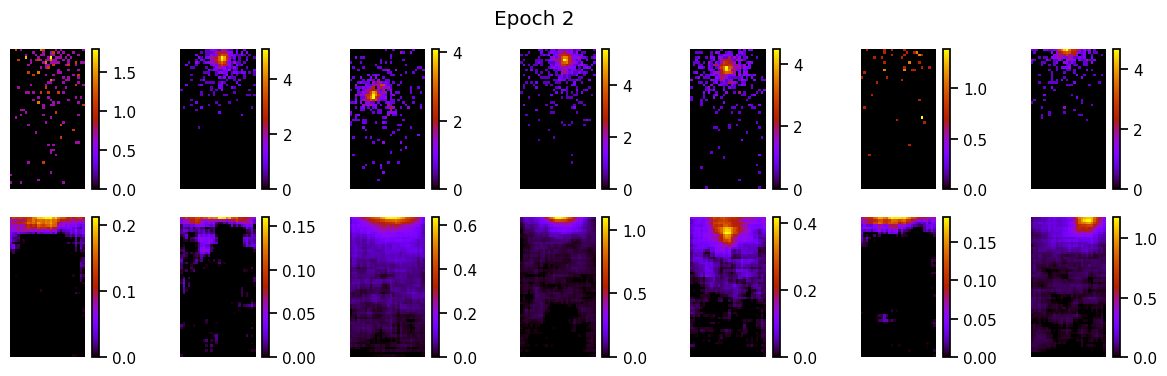

100/100 [==============================] - 0s 3ms/step
ws mean 55.54 ch1 38.94 ch2 96.63 ch3 0.52 ch4 0.46 ch5 141.15 Time for epoch 2 is 6.234021902084351 sec
300 [Total loss: 64.51] [Recon_loss: 62.44] [KL loss: 2.96]


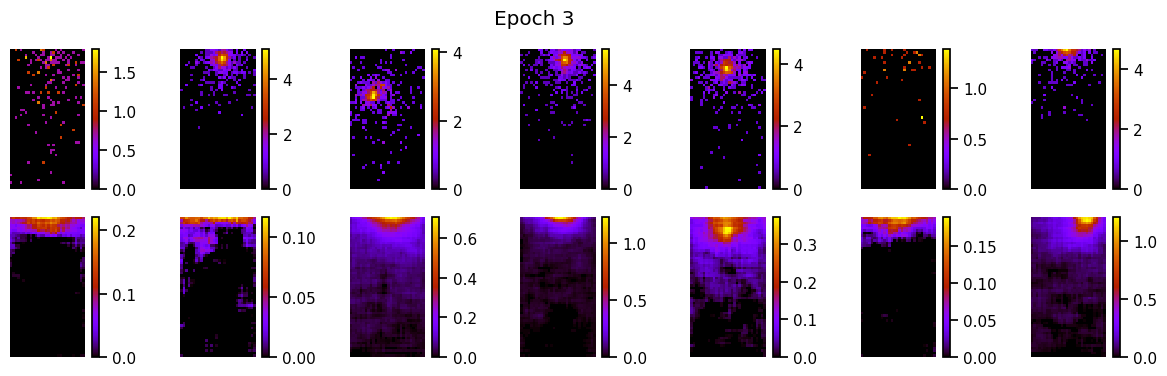

100/100 [==============================] - 0s 3ms/step
ws mean 55.77 ch1 39.21 ch2 96.55 ch3 0.64 ch4 0.60 ch5 141.86 Time for epoch 3 is 6.201199769973755 sec
400 [Total loss: 59.73] [Recon_loss: 57.72] [KL loss: 2.86]


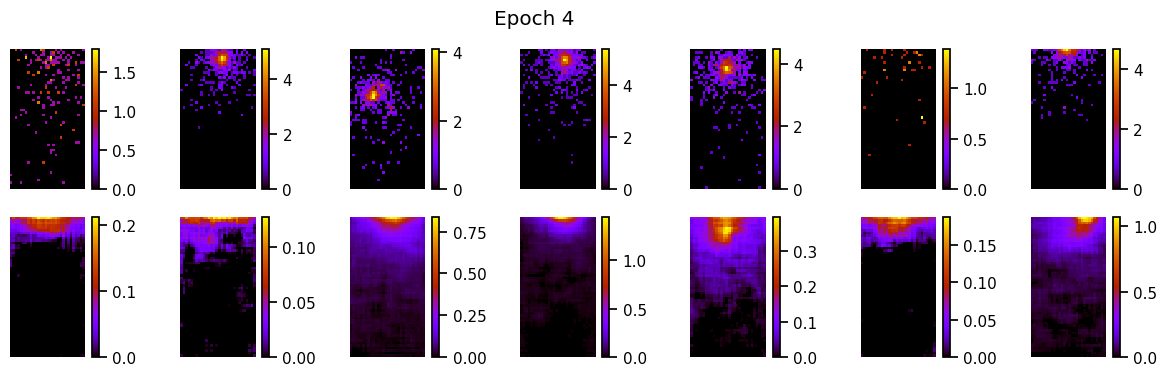

100/100 [==============================] - 0s 3ms/step
ws mean 55.16 ch1 38.86 ch2 95.05 ch3 0.79 ch4 0.74 ch5 140.35 Time for epoch 4 is 5.9874842166900635 sec
500 [Total loss: 60.79] [Recon_loss: 58.71] [KL loss: 2.97]


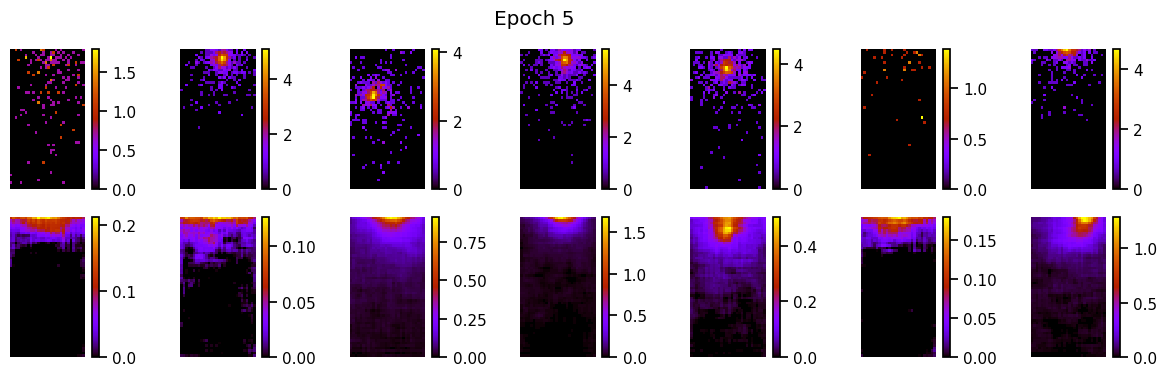

100/100 [==============================] - 0s 3ms/step
ws mean 54.37 ch1 38.73 ch2 93.55 ch3 0.67 ch4 0.71 ch5 138.20 Time for epoch 5 is 6.250871896743774 sec
600 [Total loss: 81.24] [Recon_loss: 79.04] [KL loss: 3.15]


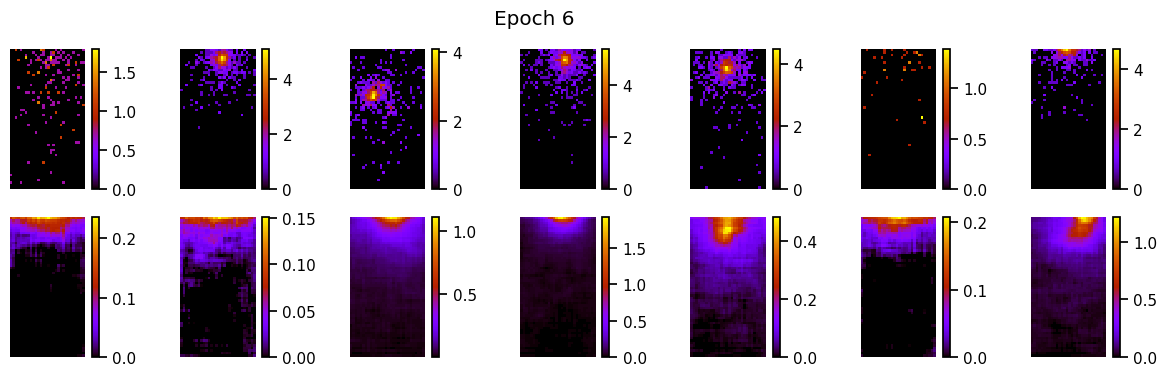

100/100 [==============================] - 0s 3ms/step
ws mean 50.55 ch1 34.97 ch2 88.48 ch3 0.75 ch4 0.83 ch5 127.75 Time for epoch 6 is 6.568613052368164 sec
700 [Total loss: 62.80] [Recon_loss: 60.83] [KL loss: 2.82]


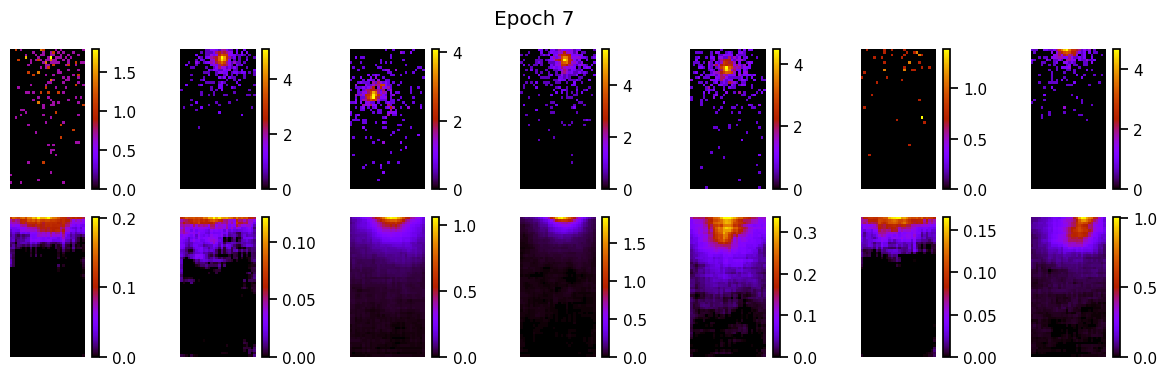

100/100 [==============================] - 0s 3ms/step
ws mean 54.16 ch1 38.67 ch2 92.80 ch3 0.76 ch4 0.75 ch5 137.81 Time for epoch 7 is 6.7903337478637695 sec
800 [Total loss: 61.45] [Recon_loss: 59.63] [KL loss: 2.60]


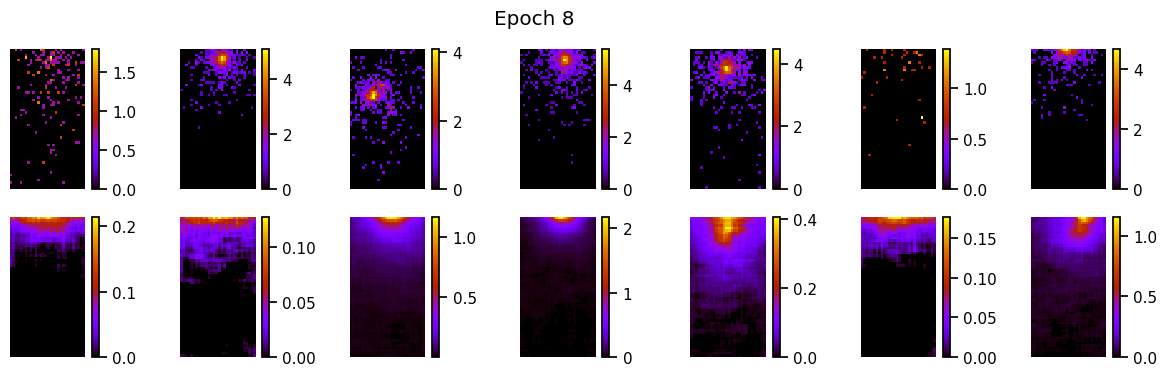

100/100 [==============================] - 0s 3ms/step
ws mean 52.56 ch1 37.13 ch2 90.40 ch3 0.76 ch4 0.74 ch5 133.76 Time for epoch 8 is 6.524134159088135 sec
900 [Total loss: 64.03] [Recon_loss: 62.02] [KL loss: 2.87]


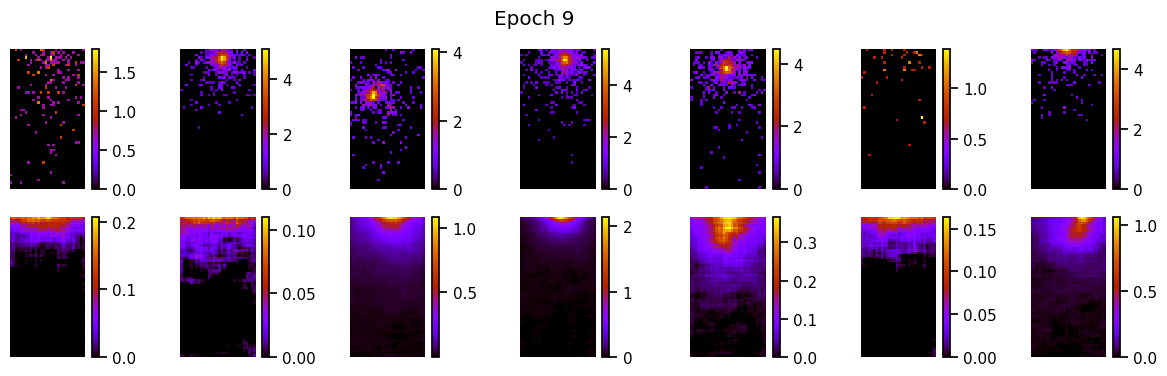

100/100 [==============================] - 0s 3ms/step
ws mean 53.23 ch1 37.86 ch2 91.18 ch3 0.83 ch4 0.79 ch5 135.50 Time for epoch 9 is 6.797917604446411 sec
1000 [Total loss: 70.35] [Recon_loss: 68.59] [KL loss: 2.51]


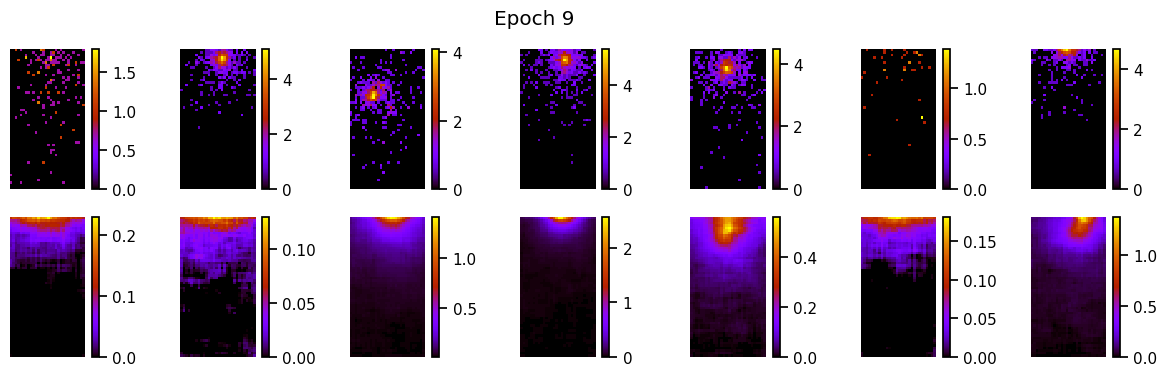

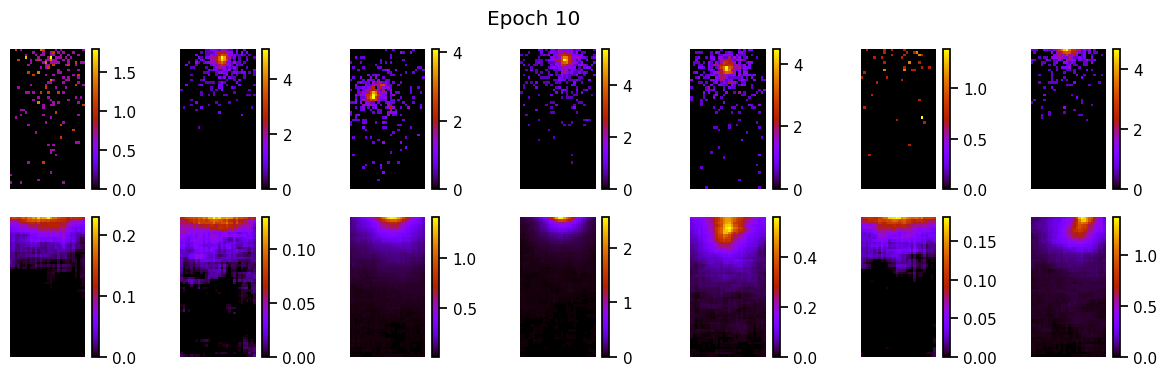

100/100 [==============================] - 0s 3ms/step
ws mean 47.26 ch1 33.37 ch2 81.75 ch3 0.72 ch4 0.71 ch5 119.74 Time for epoch 10 is 8.179362535476685 sec
1100 [Total loss: 50.67] [Recon_loss: 49.03] [KL loss: 2.34]


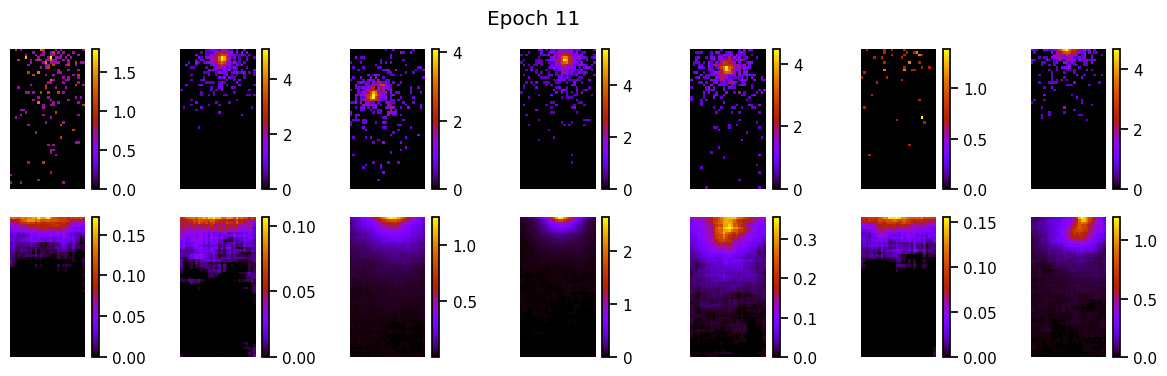

100/100 [==============================] - 0s 3ms/step
ws mean 51.76 ch1 37.02 ch2 88.31 ch3 0.81 ch4 0.80 ch5 131.84 Time for epoch 11 is 7.174347400665283 sec
1200 [Total loss: 72.77] [Recon_loss: 70.95] [KL loss: 2.60]


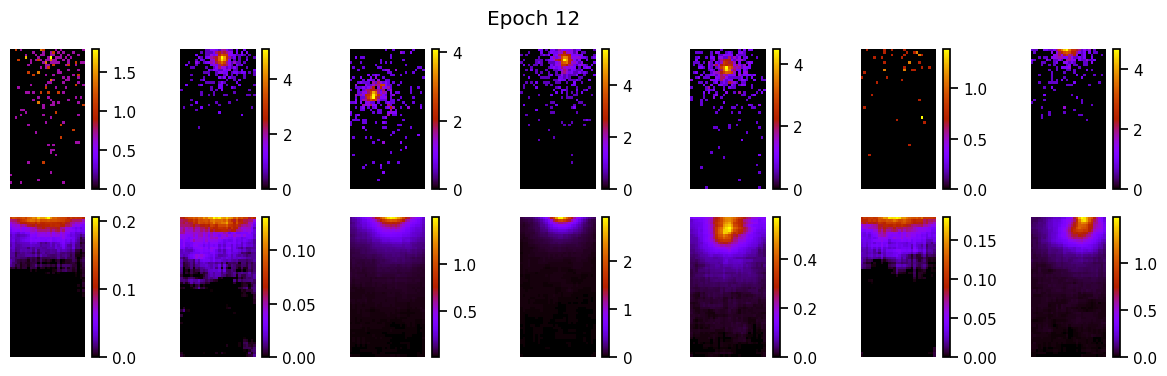

100/100 [==============================] - 0s 3ms/step
ws mean 44.94 ch1 31.72 ch2 77.53 ch3 0.68 ch4 0.69 ch5 114.07 Time for epoch 12 is 7.3712687492370605 sec
1300 [Total loss: 65.06] [Recon_loss: 63.38] [KL loss: 2.40]


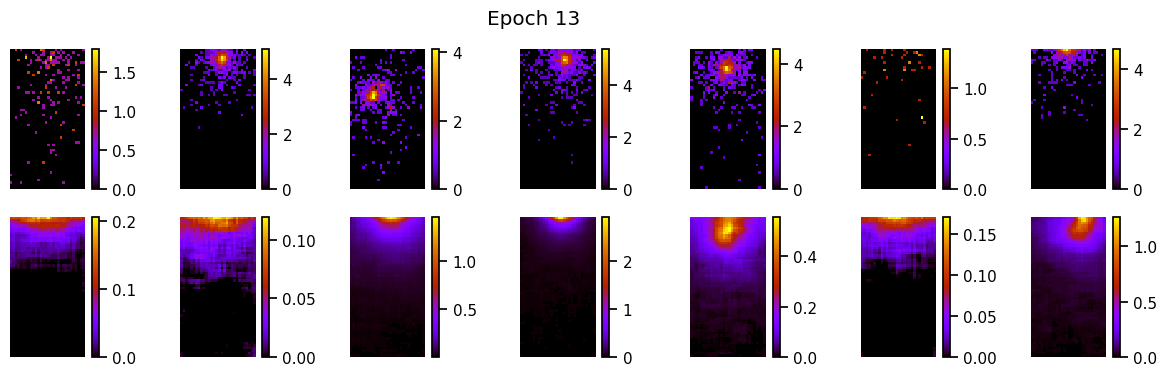

100/100 [==============================] - 0s 3ms/step
ws mean 46.94 ch1 33.19 ch2 80.64 ch3 0.70 ch4 0.69 ch5 119.48 Time for epoch 13 is 7.141799449920654 sec
1400 [Total loss: 59.55] [Recon_loss: 58.13] [KL loss: 2.03]


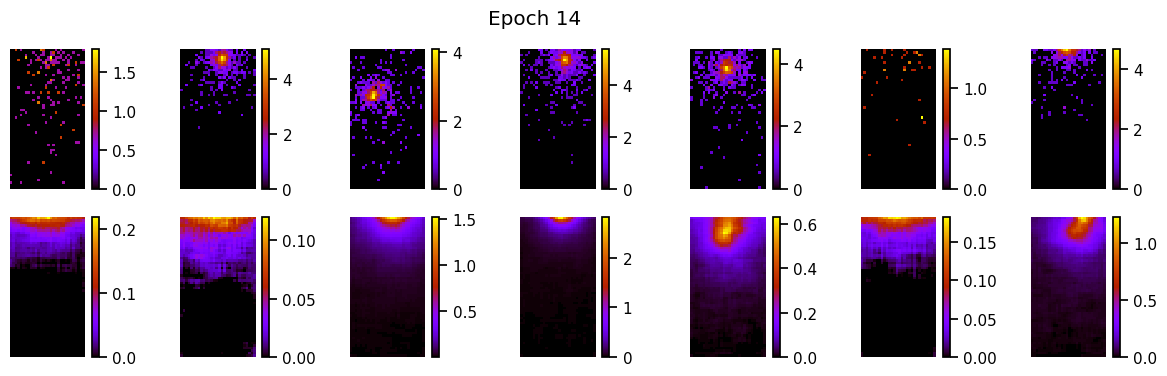

100/100 [==============================] - 0s 3ms/step
ws mean 44.90 ch1 32.39 ch2 76.57 ch3 0.68 ch4 0.67 ch5 114.19 Time for epoch 14 is 7.442145347595215 sec
1500 [Total loss: 64.79] [Recon_loss: 63.30] [KL loss: 2.13]


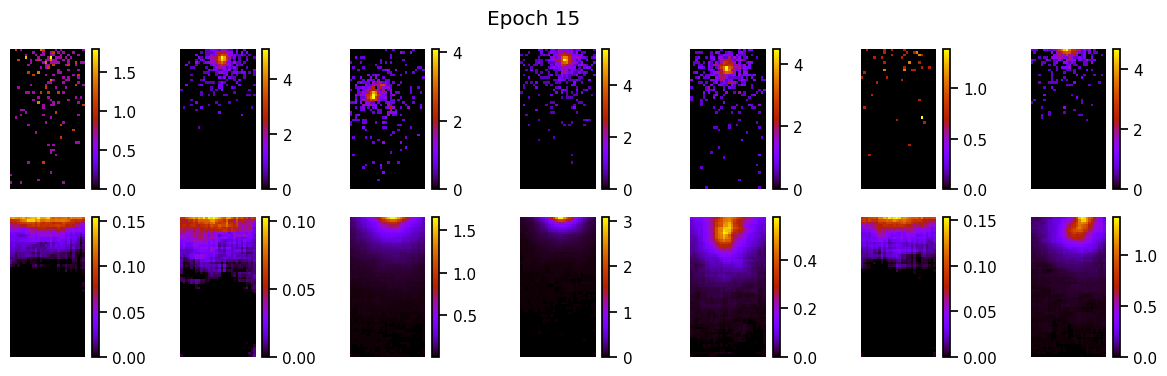

100/100 [==============================] - 0s 3ms/step
ws mean 44.80 ch1 32.45 ch2 75.86 ch3 0.73 ch4 0.72 ch5 114.25 Time for epoch 15 is 7.183542013168335 sec
1600 [Total loss: 62.61] [Recon_loss: 61.23] [KL loss: 1.97]


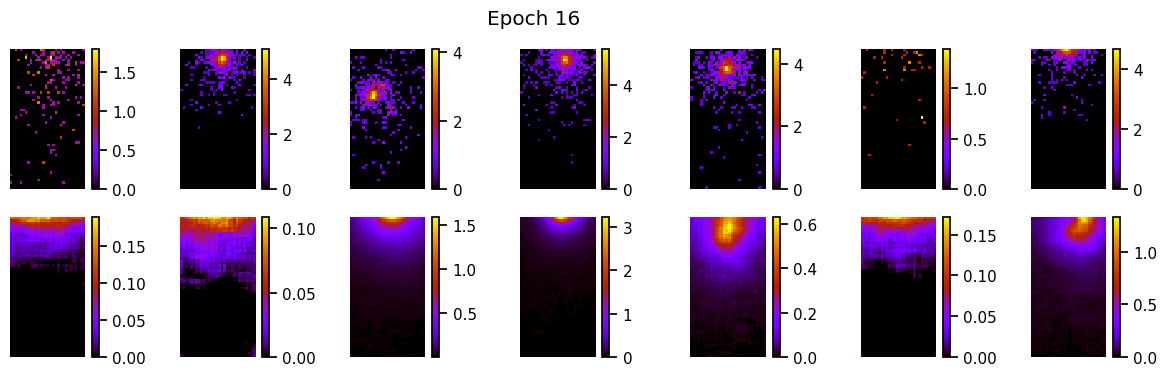

100/100 [==============================] - 0s 3ms/step
ws mean 42.55 ch1 29.99 ch2 72.94 ch3 0.68 ch4 0.65 ch5 108.51 Time for epoch 16 is 7.980579614639282 sec
1700 [Total loss: 58.37] [Recon_loss: 56.98] [KL loss: 2.00]


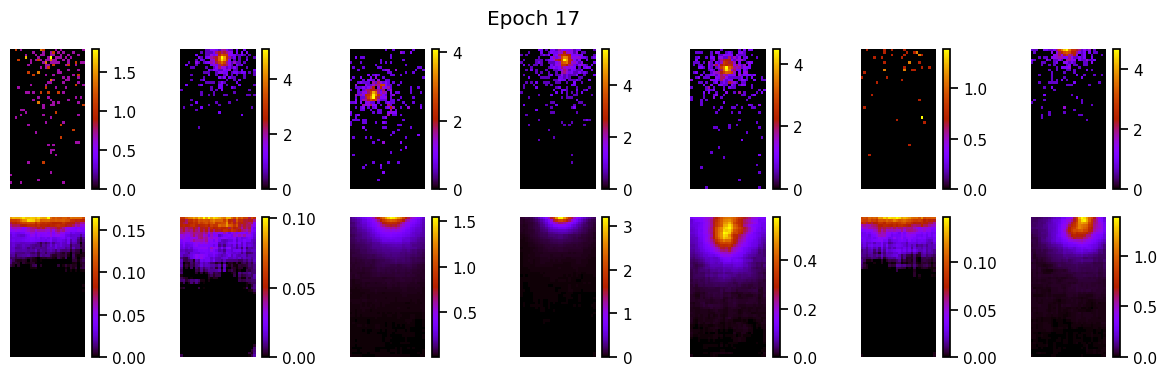

100/100 [==============================] - 0s 3ms/step
ws mean 45.40 ch1 32.87 ch2 76.62 ch3 0.84 ch4 0.84 ch5 115.83 Time for epoch 17 is 7.721157550811768 sec
1800 [Total loss: 58.47] [Recon_loss: 57.37] [KL loss: 1.57]


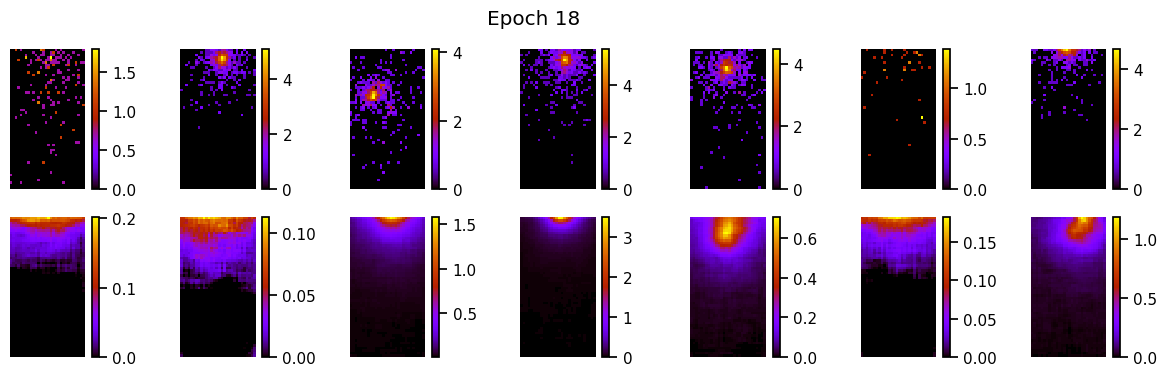

100/100 [==============================] - 0s 3ms/step
ws mean 39.72 ch1 28.00 ch2 68.08 ch3 0.70 ch4 0.66 ch5 101.16 Time for epoch 18 is 7.992473840713501 sec
1900 [Total loss: 58.35] [Recon_loss: 57.16] [KL loss: 1.70]


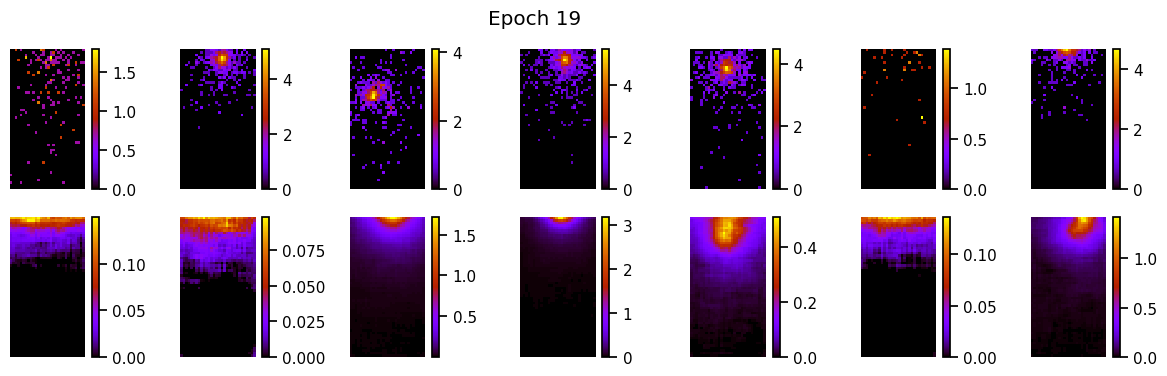

100/100 [==============================] - 0s 3ms/step
ws mean 41.09 ch1 30.49 ch2 68.39 ch3 0.81 ch4 0.79 ch5 105.00 Time for epoch 19 is 8.015165567398071 sec
2000 [Total loss: 58.49] [Recon_loss: 57.32] [KL loss: 1.67]


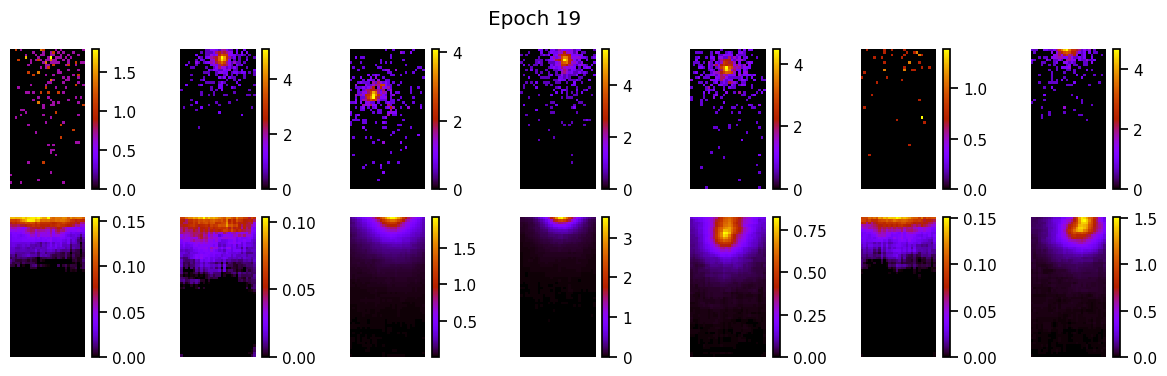

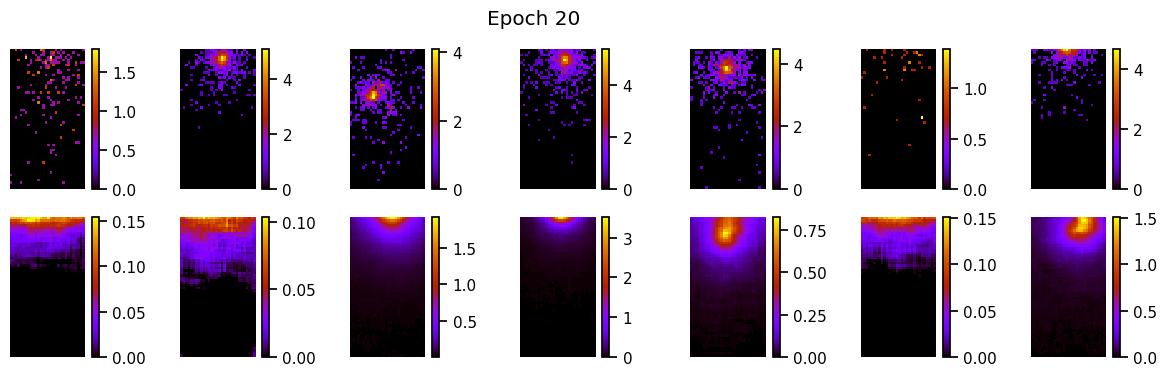

100/100 [==============================] - 0s 3ms/step
ws mean 35.80 ch1 25.86 ch2 60.28 ch3 0.76 ch4 0.74 ch5 91.34 Time for epoch 20 is 9.600803852081299 sec
2100 [Total loss: 56.24] [Recon_loss: 54.96] [KL loss: 1.82]


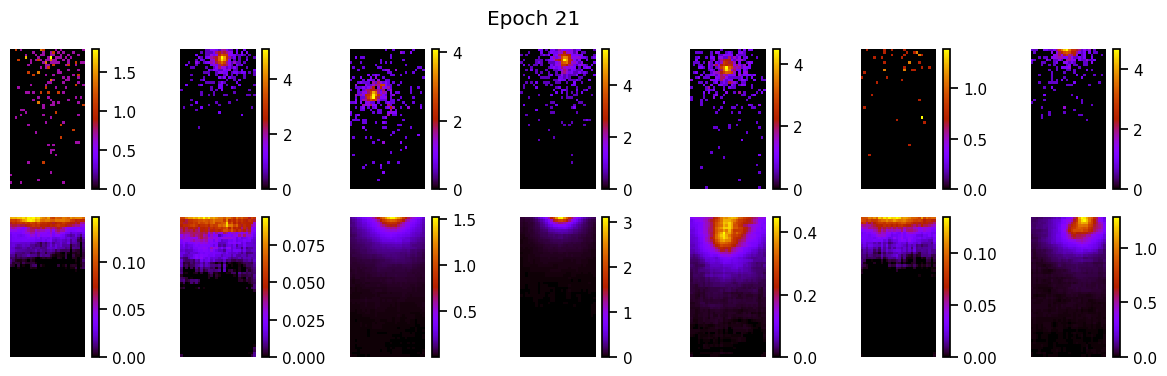

100/100 [==============================] - 0s 3ms/step
ws mean 44.69 ch1 33.18 ch2 74.47 ch3 0.86 ch4 0.84 ch5 114.09 Time for epoch 21 is 8.277637243270874 sec
2200 [Total loss: 58.61] [Recon_loss: 57.43] [KL loss: 1.69]


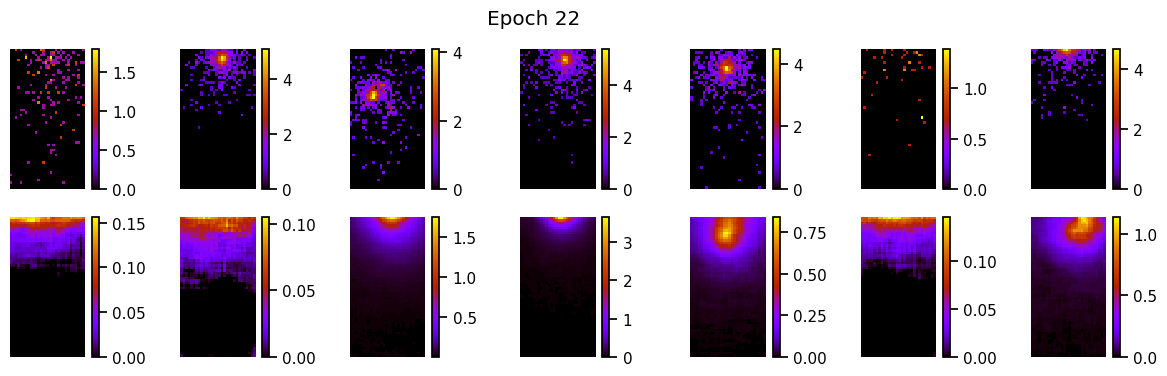

100/100 [==============================] - 0s 3ms/step
ws mean 36.68 ch1 26.66 ch2 61.61 ch3 0.71 ch4 0.68 ch5 93.73 Time for epoch 22 is 8.65825629234314 sec
2300 [Total loss: 64.91] [Recon_loss: 63.46] [KL loss: 2.07]


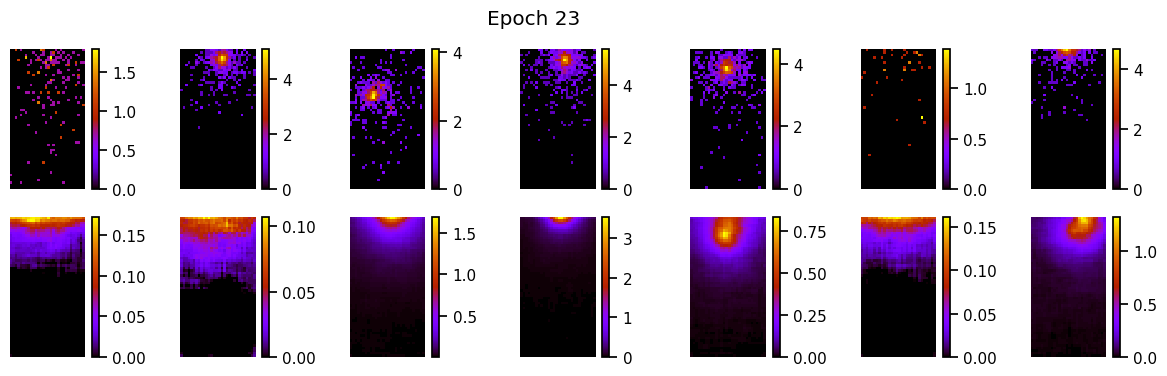

100/100 [==============================] - 0s 3ms/step
ws mean 39.25 ch1 27.89 ch2 66.93 ch3 0.70 ch4 0.70 ch5 100.02 Time for epoch 23 is 8.320101261138916 sec
2400 [Total loss: 58.15] [Recon_loss: 57.04] [KL loss: 1.59]


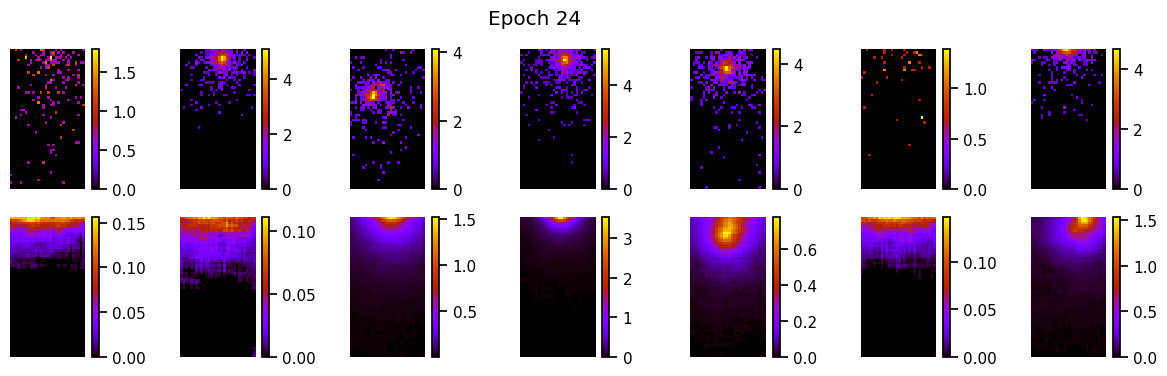

100/100 [==============================] - 0s 3ms/step
ws mean 40.46 ch1 28.92 ch2 68.53 ch3 0.79 ch4 0.76 ch5 103.30 Time for epoch 24 is 8.60269546508789 sec
2500 [Total loss: 61.72] [Recon_loss: 60.35] [KL loss: 1.96]


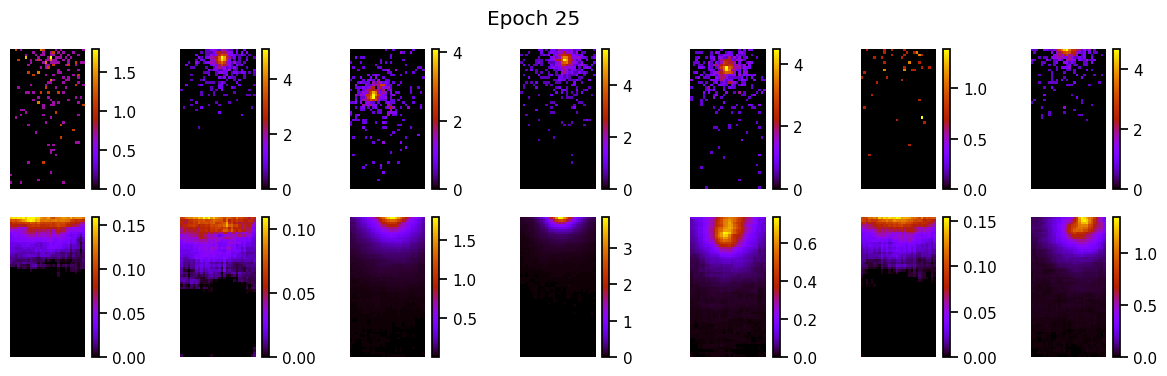

100/100 [==============================] - 0s 3ms/step
ws mean 36.77 ch1 27.26 ch2 61.55 ch3 0.68 ch4 0.67 ch5 93.69 Time for epoch 25 is 8.35285758972168 sec
2600 [Total loss: 60.44] [Recon_loss: 59.07] [KL loss: 1.96]


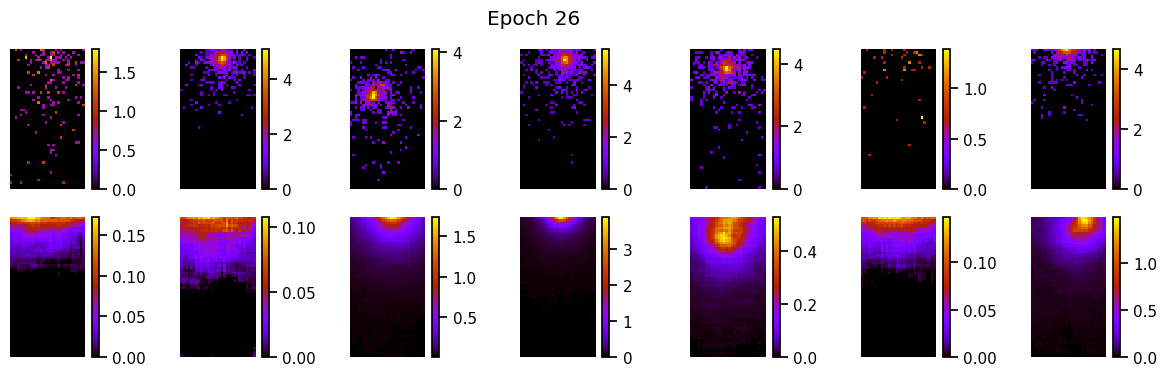

100/100 [==============================] - 0s 3ms/step
ws mean 36.31 ch1 26.58 ch2 61.09 ch3 0.66 ch4 0.67 ch5 92.56 Time for epoch 26 is 8.685672521591187 sec
2700 [Total loss: 53.54] [Recon_loss: 52.54] [KL loss: 1.43]


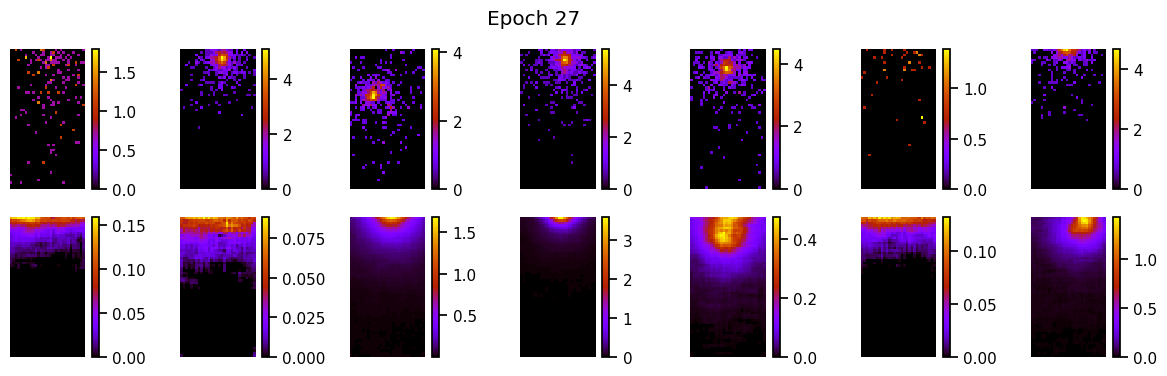

100/100 [==============================] - 0s 3ms/step
ws mean 40.66 ch1 30.05 ch2 67.25 ch3 1.10 ch4 1.08 ch5 103.80 Time for epoch 27 is 8.403050184249878 sec
2800 [Total loss: 57.37] [Recon_loss: 56.36] [KL loss: 1.45]


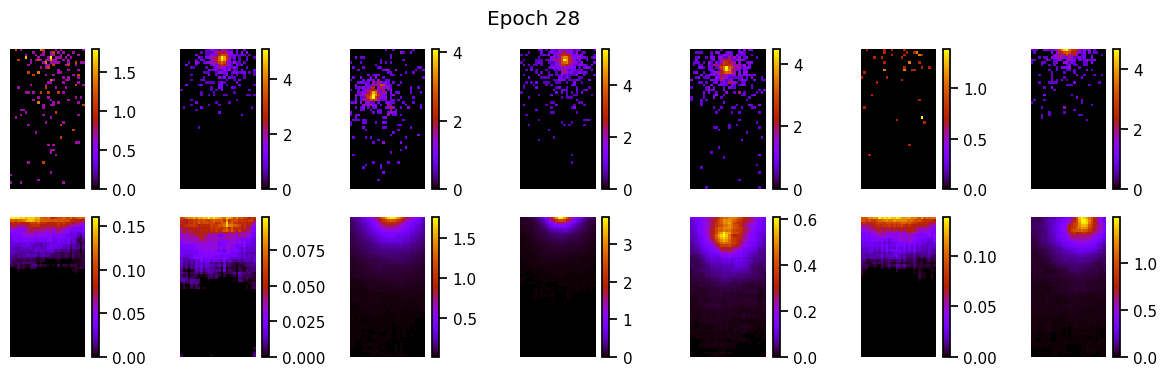

100/100 [==============================] - 0s 3ms/step
ws mean 37.37 ch1 27.59 ch2 62.41 ch3 0.76 ch4 0.73 ch5 95.37 Time for epoch 28 is 8.759335994720459 sec
2900 [Total loss: 66.42] [Recon_loss: 65.15] [KL loss: 1.81]


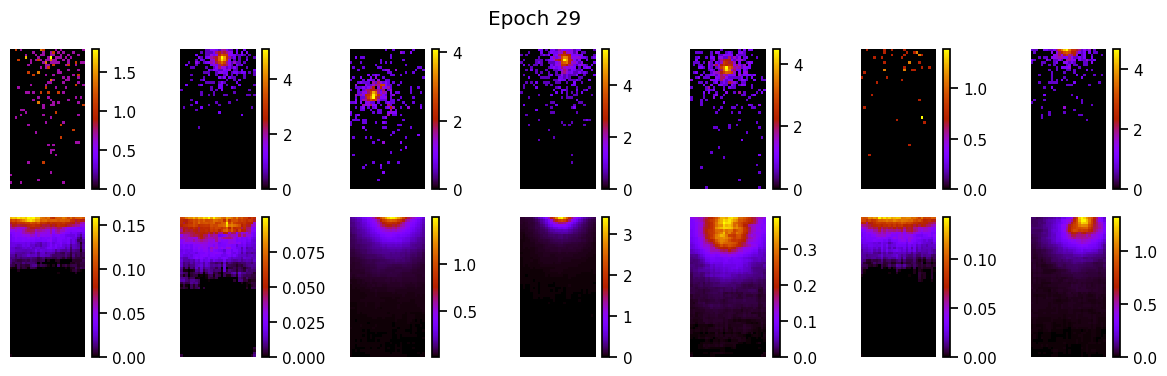

100/100 [==============================] - 0s 3ms/step
ws mean 43.42 ch1 32.41 ch2 72.31 ch3 0.86 ch4 0.81 ch5 110.71 Time for epoch 29 is 8.497074842453003 sec
3000 [Total loss: 66.66] [Recon_loss: 65.25] [KL loss: 2.01]


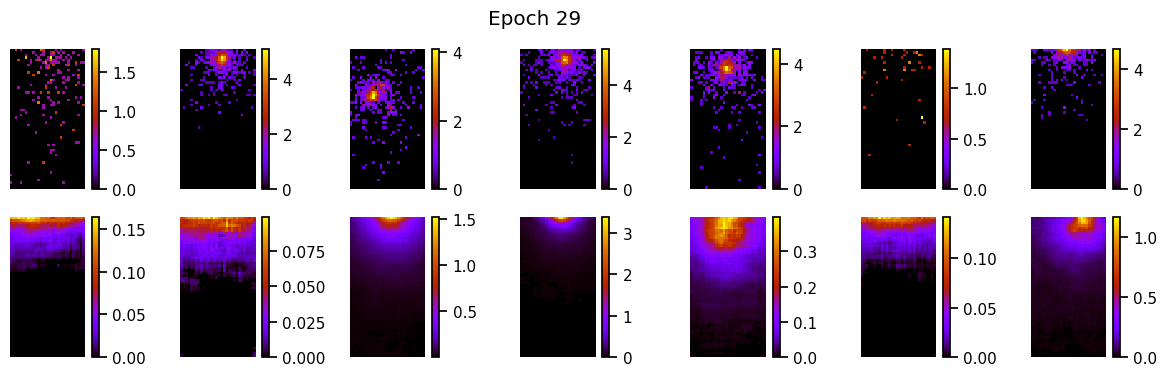

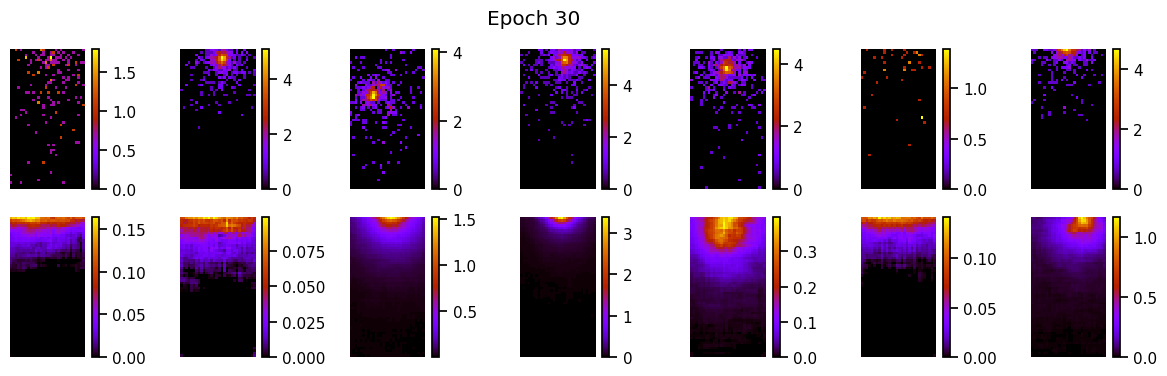

100/100 [==============================] - 0s 3ms/step
ws mean 43.09 ch1 31.47 ch2 72.33 ch3 0.91 ch4 0.81 ch5 109.94 Time for epoch 30 is 10.118189573287964 sec
3100 [Total loss: 58.69] [Recon_loss: 57.71] [KL loss: 1.40]


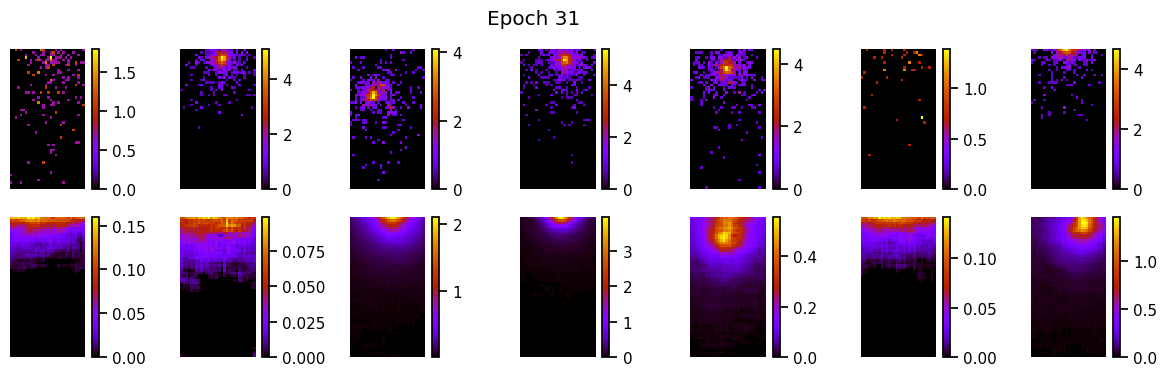

100/100 [==============================] - 0s 4ms/step
ws mean 33.06 ch1 25.05 ch2 54.27 ch3 0.82 ch4 0.81 ch5 84.35 Time for epoch 31 is 8.816821336746216 sec
3200 [Total loss: 57.31] [Recon_loss: 56.24] [KL loss: 1.53]


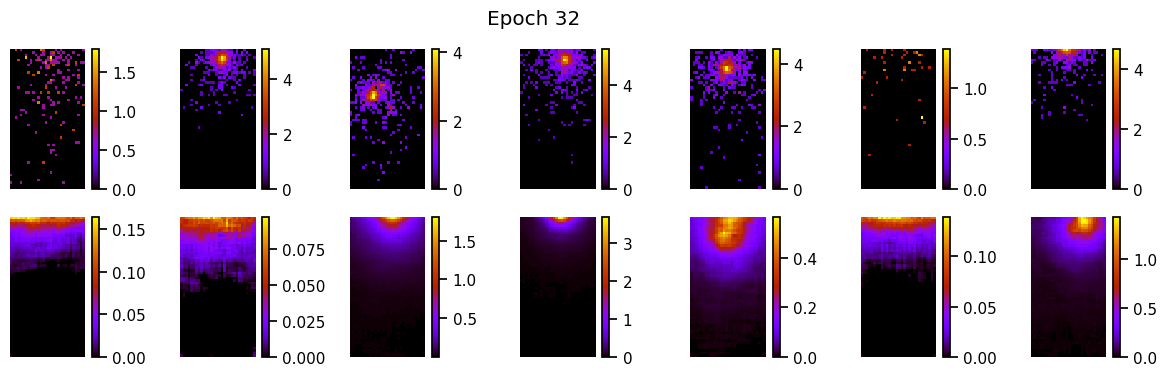

100/100 [==============================] - 0s 4ms/step
ws mean 37.99 ch1 28.57 ch2 62.68 ch3 0.87 ch4 0.85 ch5 96.96 Time for epoch 32 is 8.55200743675232 sec
3300 [Total loss: 59.52] [Recon_loss: 58.47] [KL loss: 1.49]


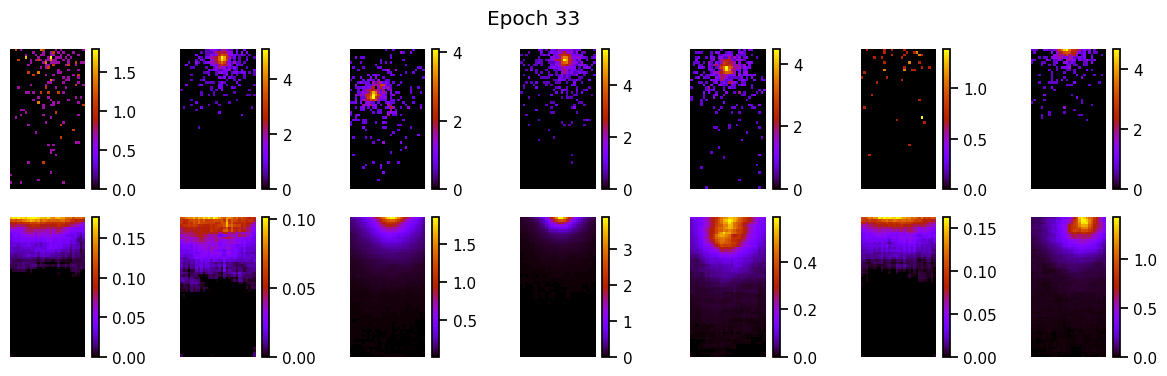

100/100 [==============================] - 0s 3ms/step
ws mean 34.74 ch1 25.71 ch2 57.75 ch3 0.80 ch4 0.77 ch5 88.66 Time for epoch 33 is 8.800998449325562 sec
3400 [Total loss: 57.96] [Recon_loss: 56.87] [KL loss: 1.55]


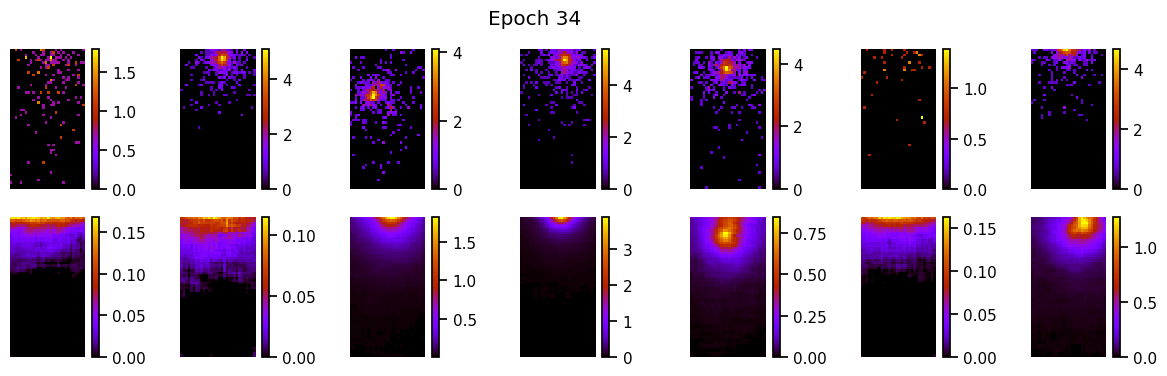

100/100 [==============================] - 0s 3ms/step
ws mean 35.48 ch1 26.84 ch2 58.55 ch3 0.76 ch4 0.75 ch5 90.49 Time for epoch 34 is 8.732316493988037 sec
3500 [Total loss: 52.35] [Recon_loss: 51.53] [KL loss: 1.18]


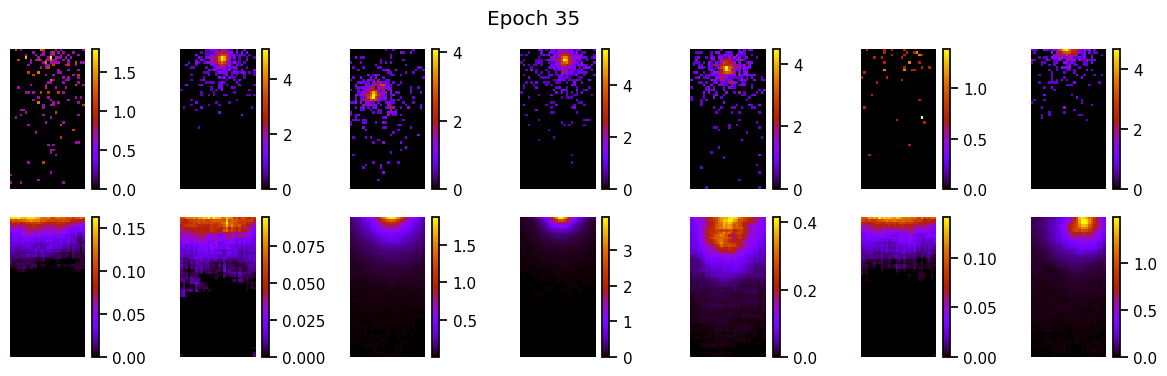

100/100 [==============================] - 0s 3ms/step
ws mean 35.92 ch1 27.24 ch2 58.80 ch3 0.94 ch4 0.92 ch5 91.70 Time for epoch 35 is 8.438862800598145 sec
3600 [Total loss: 69.88] [Recon_loss: 68.52] [KL loss: 1.95]


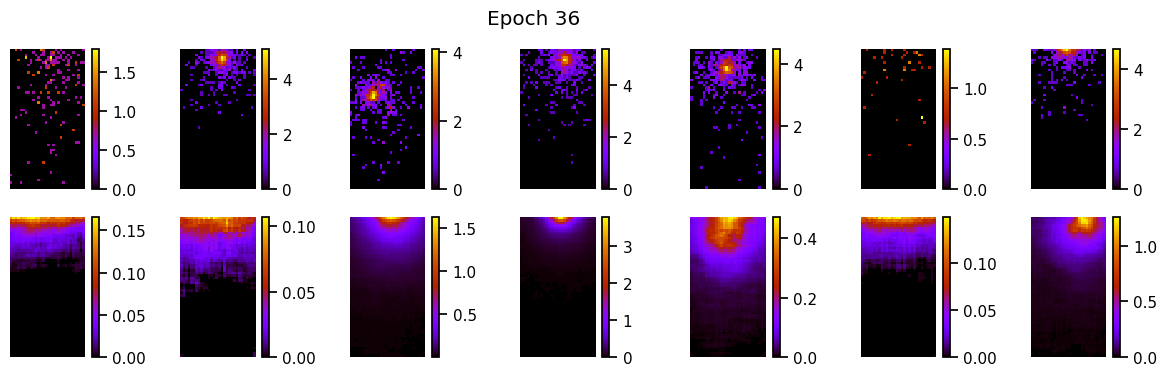

100/100 [==============================] - 0s 4ms/step
ws mean 40.97 ch1 29.88 ch2 68.86 ch3 0.84 ch4 0.83 ch5 104.43 Time for epoch 36 is 8.617652654647827 sec
3700 [Total loss: 61.11] [Recon_loss: 59.91] [KL loss: 1.72]


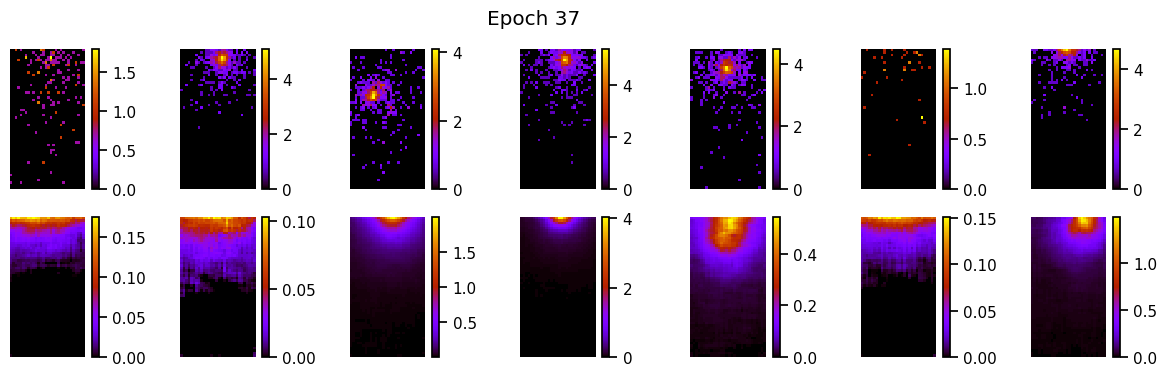

100/100 [==============================] - 0s 3ms/step
ws mean 32.97 ch1 25.24 ch2 54.22 ch3 0.74 ch4 0.72 ch5 83.90 Time for epoch 37 is 8.329306602478027 sec
3800 [Total loss: 52.10] [Recon_loss: 51.20] [KL loss: 1.28]


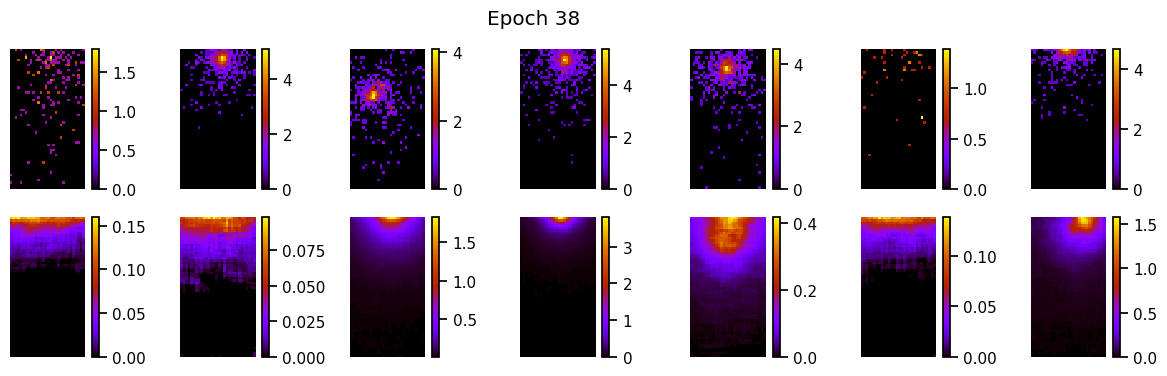

100/100 [==============================] - 0s 3ms/step
ws mean 37.69 ch1 28.56 ch2 61.82 ch3 0.97 ch4 0.95 ch5 96.12 Time for epoch 38 is 8.601109504699707 sec
3900 [Total loss: 61.94] [Recon_loss: 60.91] [KL loss: 1.47]


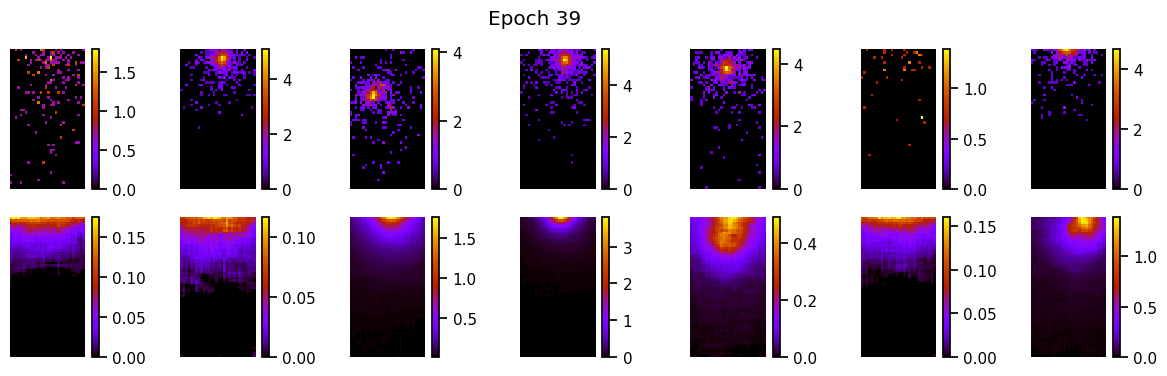

100/100 [==============================] - 0s 3ms/step
ws mean 37.46 ch1 28.26 ch2 61.96 ch3 0.80 ch4 0.79 ch5 95.49 Time for epoch 39 is 8.300219535827637 sec
4000 [Total loss: 59.37] [Recon_loss: 58.39] [KL loss: 1.41]


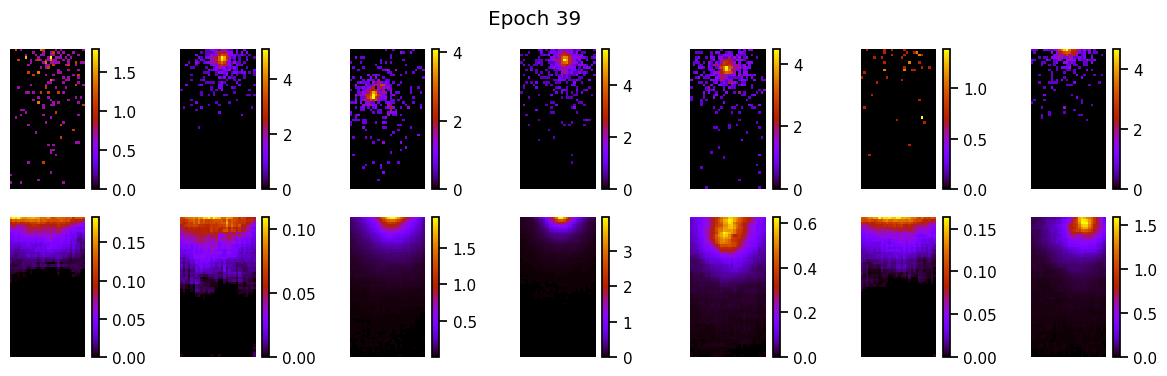

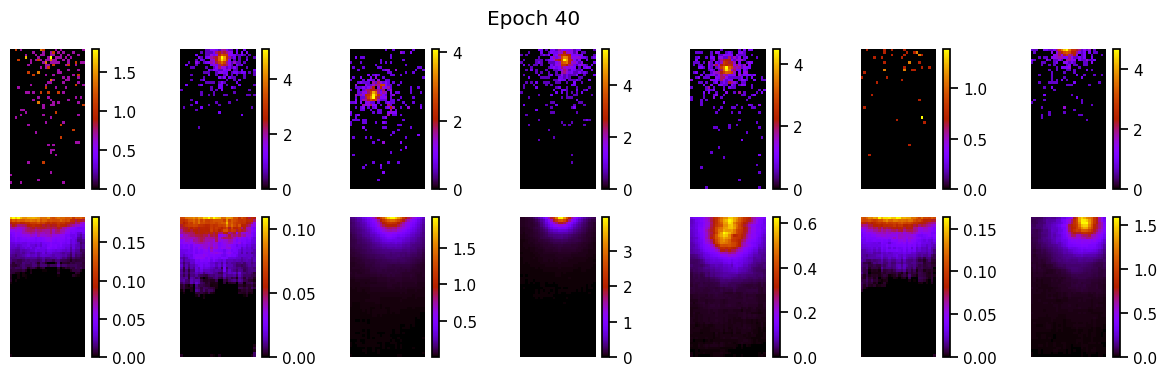

100/100 [==============================] - 0s 3ms/step
ws mean 32.13 ch1 24.80 ch2 52.63 ch3 0.70 ch4 0.70 ch5 81.84 Time for epoch 40 is 9.920483350753784 sec
4100 [Total loss: 57.25] [Recon_loss: 56.24] [KL loss: 1.44]


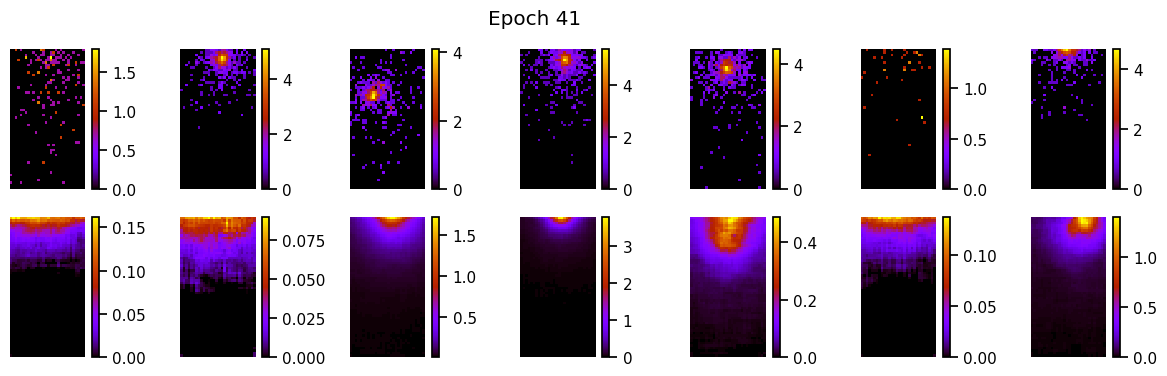

100/100 [==============================] - 0s 3ms/step
ws mean 39.04 ch1 29.45 ch2 64.45 ch3 0.89 ch4 0.86 ch5 99.56 Time for epoch 41 is 8.544105529785156 sec
4200 [Total loss: 67.28] [Recon_loss: 66.04] [KL loss: 1.78]


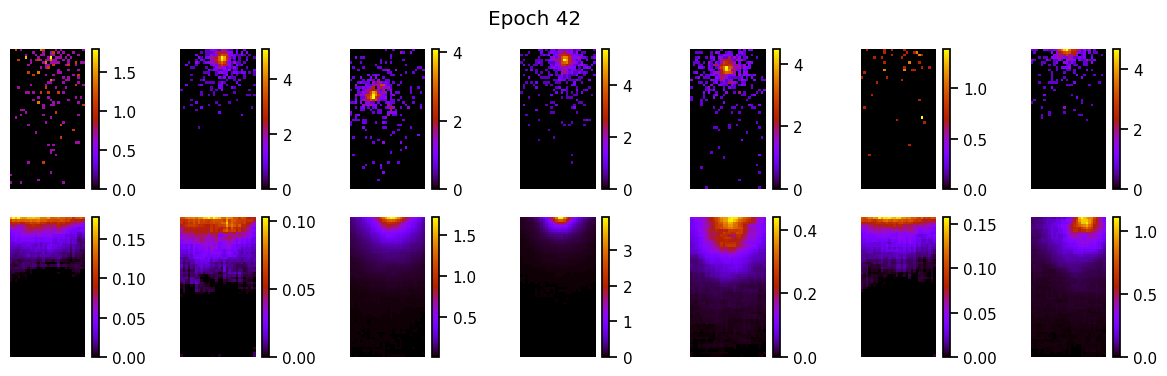

100/100 [==============================] - 0s 3ms/step
ws mean 38.94 ch1 29.17 ch2 64.73 ch3 0.78 ch4 0.77 ch5 99.25 Time for epoch 42 is 8.271679878234863 sec
4300 [Total loss: 59.51] [Recon_loss: 58.55] [KL loss: 1.36]


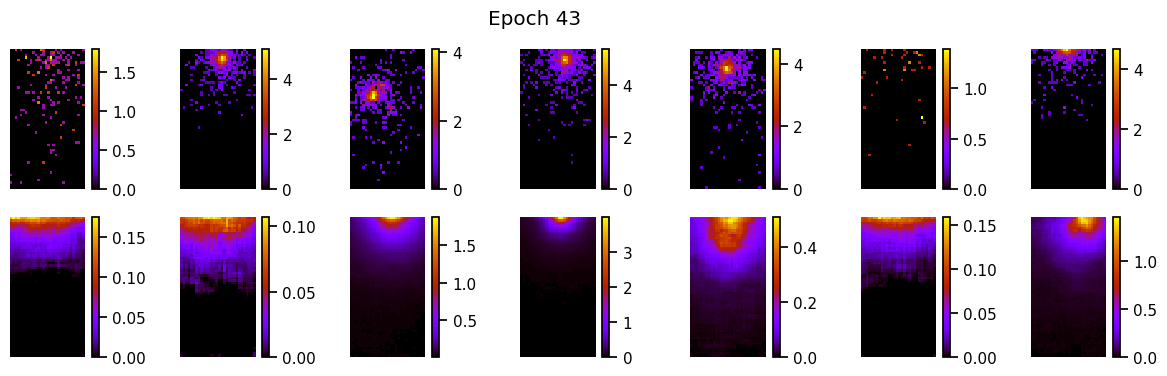

100/100 [==============================] - 0s 3ms/step
ws mean 34.26 ch1 26.58 ch2 55.92 ch3 0.73 ch4 0.72 ch5 87.34 Time for epoch 43 is 8.515366792678833 sec
4400 [Total loss: 60.92] [Recon_loss: 59.97] [KL loss: 1.36]


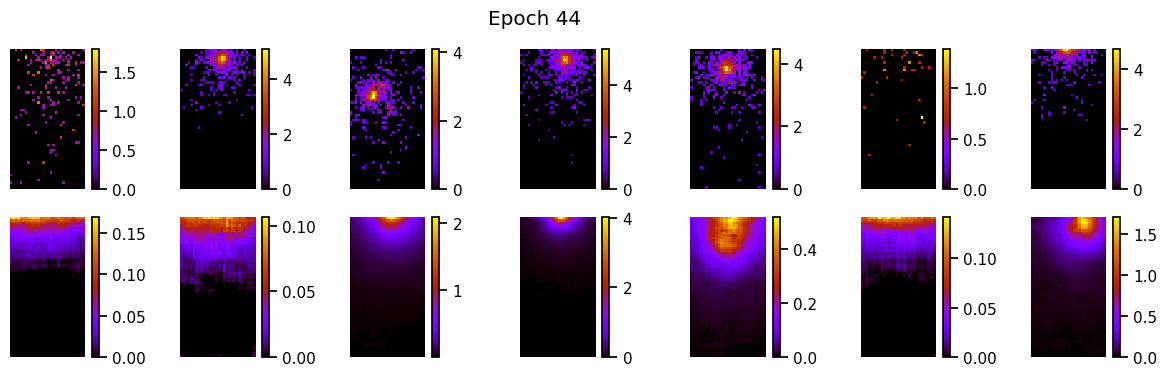

100/100 [==============================] - 0s 3ms/step
ws mean 28.92 ch1 22.92 ch2 46.49 ch3 0.81 ch4 0.80 ch5 73.60 Time for epoch 44 is 8.208152055740356 sec
4500 [Total loss: 59.79] [Recon_loss: 58.63] [KL loss: 1.66]


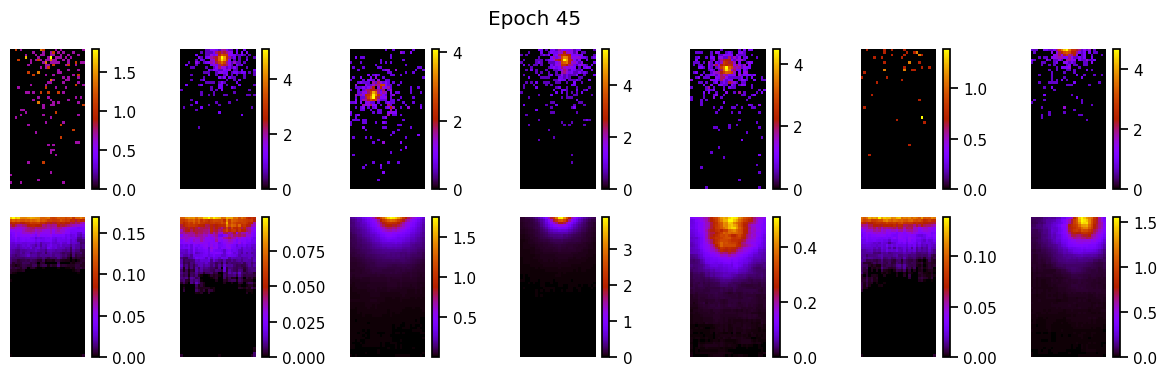

100/100 [==============================] - 0s 3ms/step
ws mean 34.63 ch1 26.55 ch2 56.58 ch3 0.83 ch4 0.79 ch5 88.41 Time for epoch 45 is 8.773203611373901 sec
4600 [Total loss: 60.15] [Recon_loss: 59.12] [KL loss: 1.47]


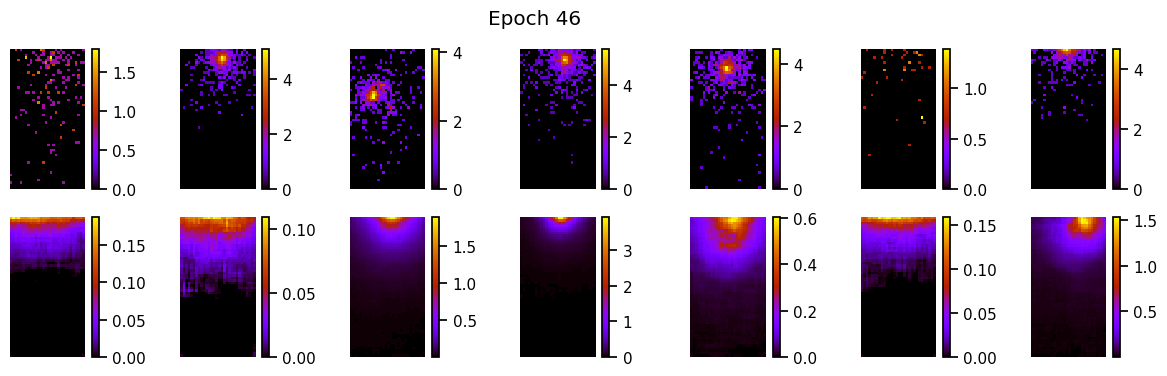

100/100 [==============================] - 0s 3ms/step
ws mean 33.09 ch1 25.16 ch2 54.65 ch3 0.69 ch4 0.71 ch5 84.26 Time for epoch 46 is 8.583667516708374 sec
4700 [Total loss: 58.60] [Recon_loss: 57.55] [KL loss: 1.49]


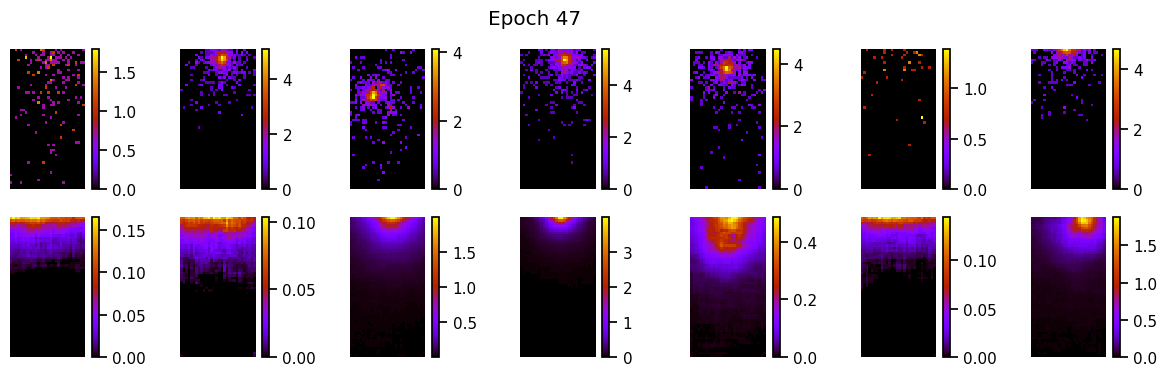

100/100 [==============================] - 0s 3ms/step
ws mean 32.33 ch1 25.30 ch2 51.76 ch3 1.03 ch4 0.99 ch5 82.58 Time for epoch 47 is 8.34116530418396 sec
4800 [Total loss: 63.10] [Recon_loss: 61.98] [KL loss: 1.60]


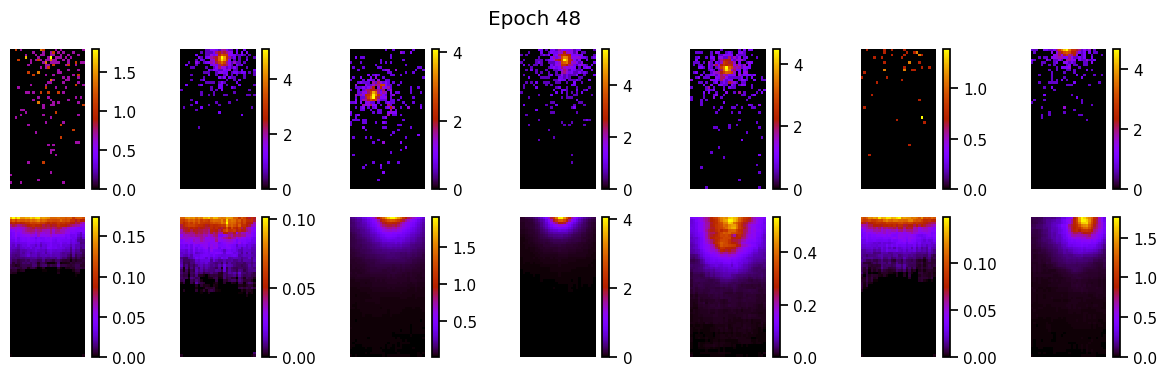

100/100 [==============================] - 0s 3ms/step
ws mean 32.81 ch1 25.37 ch2 53.22 ch3 0.87 ch4 0.86 ch5 83.74 Time for epoch 48 is 8.558588027954102 sec
4900 [Total loss: 58.74] [Recon_loss: 57.94] [KL loss: 1.15]


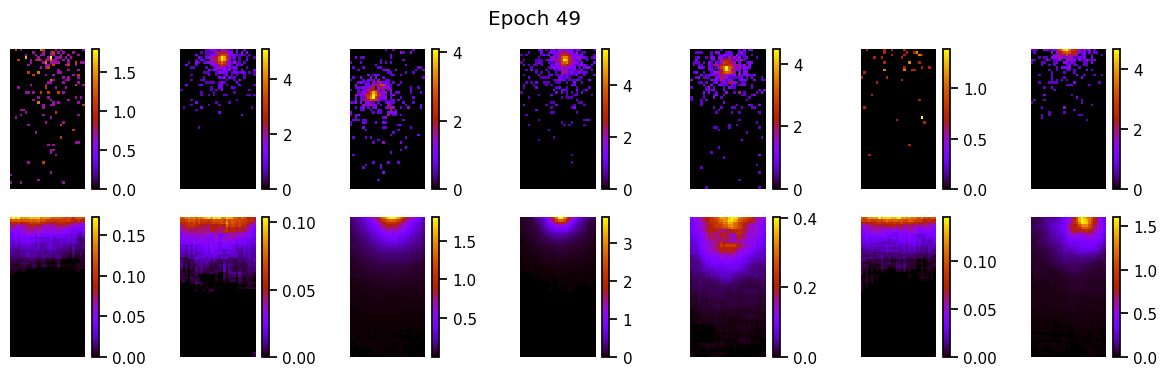

100/100 [==============================] - 0s 3ms/step
ws mean 35.79 ch1 27.20 ch2 58.40 ch3 1.04 ch4 0.94 ch5 91.39 Time for epoch 49 is 8.271352529525757 sec
5000 [Total loss: 59.39] [Recon_loss: 58.39] [KL loss: 1.43]


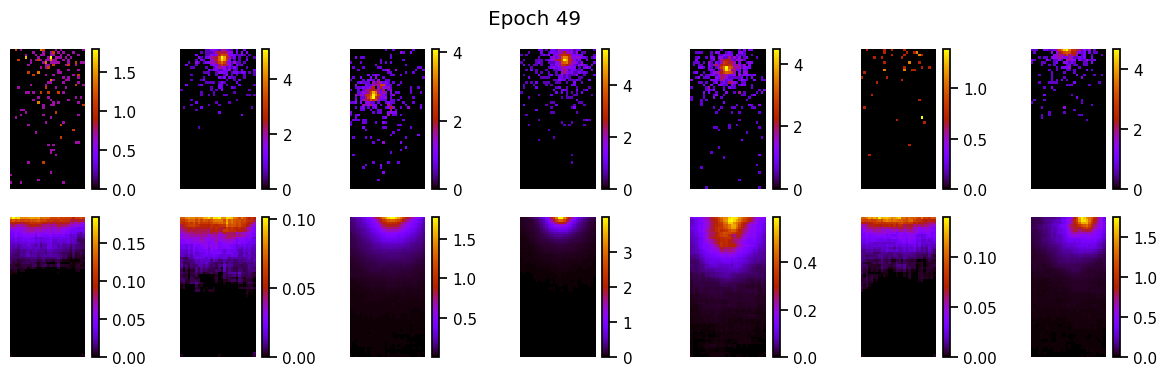

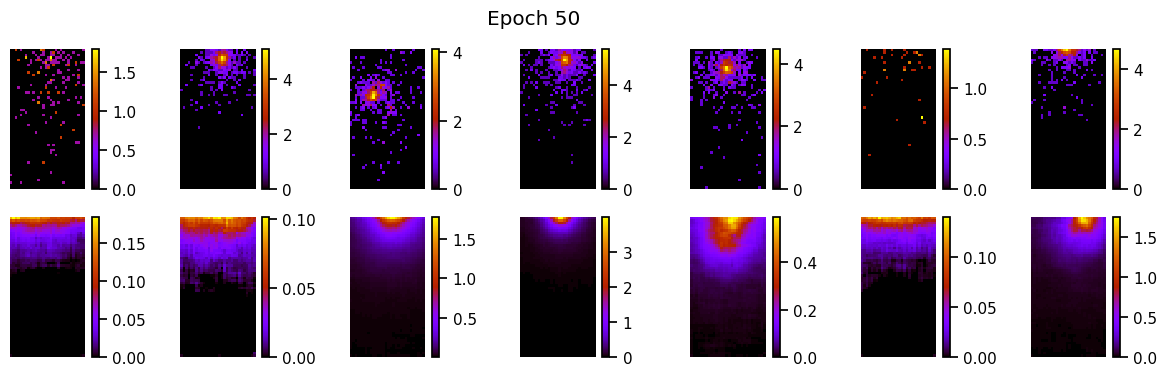

100/100 [==============================] - 0s 3ms/step
ws mean 31.28 ch1 24.06 ch2 50.69 ch3 0.95 ch4 0.91 ch5 79.78 Time for epoch 50 is 9.961848735809326 sec
5100 [Total loss: 53.83] [Recon_loss: 53.08] [KL loss: 1.07]


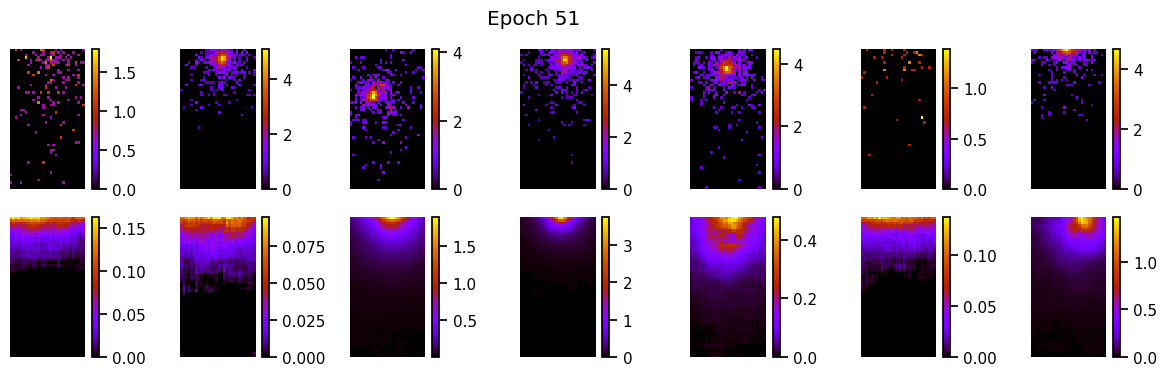

100/100 [==============================] - 0s 3ms/step
ws mean 34.50 ch1 26.98 ch2 55.55 ch3 0.97 ch4 0.95 ch5 88.05 Time for epoch 51 is 8.618890523910522 sec
5200 [Total loss: 57.60] [Recon_loss: 56.82] [KL loss: 1.12]


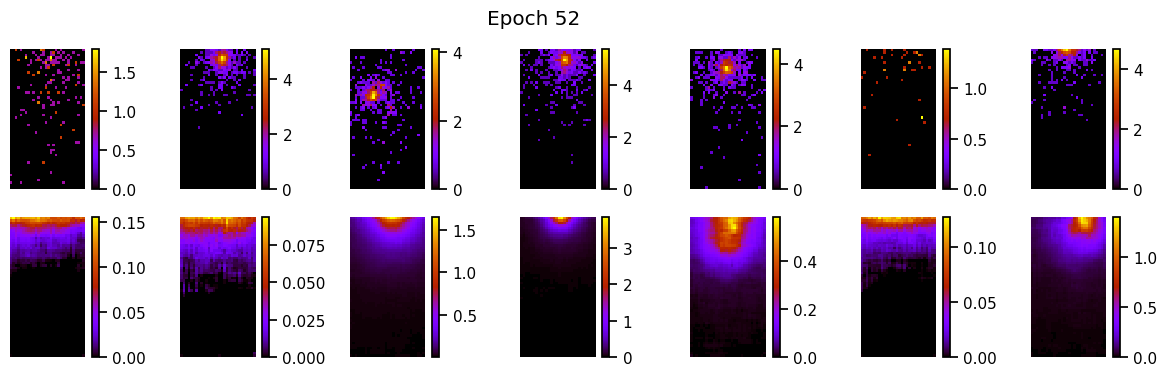

100/100 [==============================] - 0s 3ms/step
ws mean 36.55 ch1 27.40 ch2 60.05 ch3 1.01 ch4 1.02 ch5 93.26 Time for epoch 52 is 8.283982038497925 sec
5300 [Total loss: 63.93] [Recon_loss: 62.83] [KL loss: 1.56]


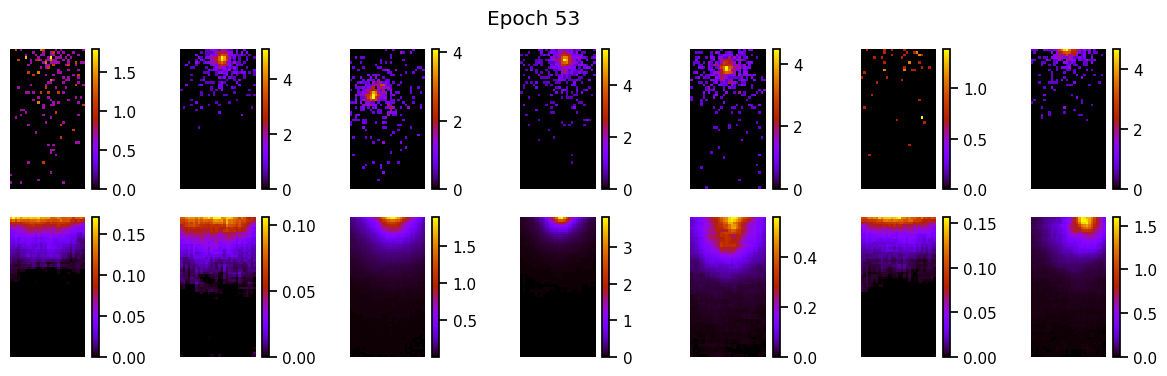

100/100 [==============================] - 0s 3ms/step
ws mean 33.40 ch1 26.15 ch2 53.99 ch3 0.82 ch4 0.83 ch5 85.20 Time for epoch 53 is 8.578118801116943 sec
5400 [Total loss: 63.19] [Recon_loss: 62.02] [KL loss: 1.67]


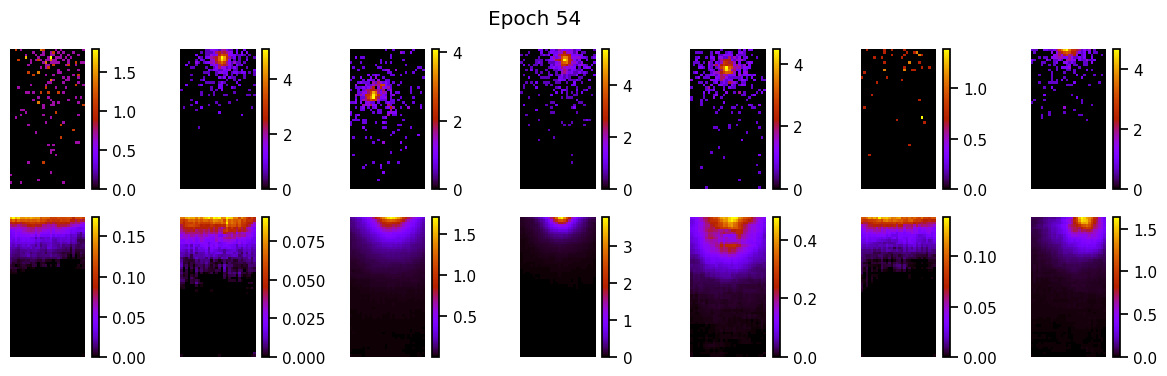

100/100 [==============================] - 0s 3ms/step
ws mean 38.43 ch1 28.96 ch2 62.96 ch3 1.11 ch4 1.08 ch5 98.01 Time for epoch 54 is 8.31639575958252 sec
5500 [Total loss: 55.04] [Recon_loss: 54.16] [KL loss: 1.26]


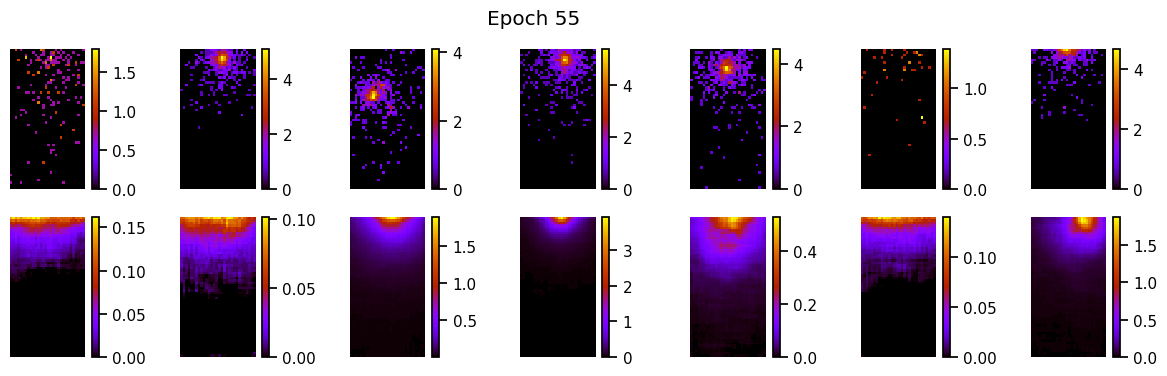

100/100 [==============================] - 0s 3ms/step
ws mean 31.17 ch1 24.24 ch2 50.25 ch3 0.88 ch4 0.88 ch5 79.61 Time for epoch 55 is 8.592941999435425 sec
5600 [Total loss: 52.49] [Recon_loss: 51.77] [KL loss: 1.04]


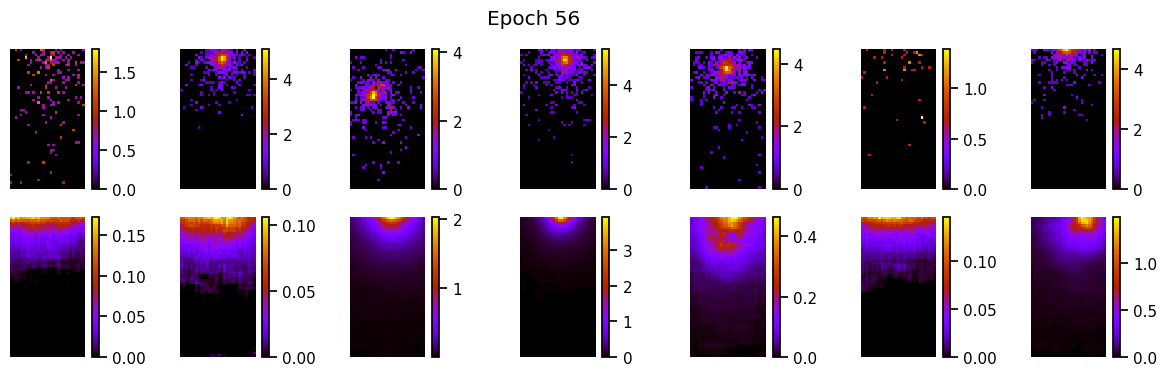

100/100 [==============================] - 0s 3ms/step
ws mean 29.72 ch1 24.03 ch2 47.20 ch3 0.83 ch4 0.80 ch5 75.73 Time for epoch 56 is 8.280375480651855 sec
5700 [Total loss: 55.49] [Recon_loss: 54.55] [KL loss: 1.34]


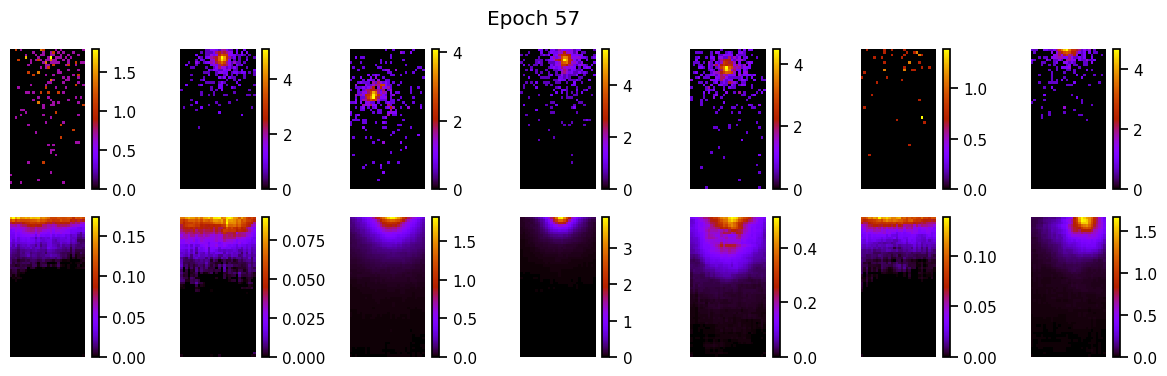

100/100 [==============================] - 0s 3ms/step
ws mean 35.01 ch1 27.19 ch2 56.30 ch3 1.14 ch4 1.10 ch5 89.33 Time for epoch 57 is 8.657658338546753 sec
5800 [Total loss: 59.43] [Recon_loss: 58.55] [KL loss: 1.25]


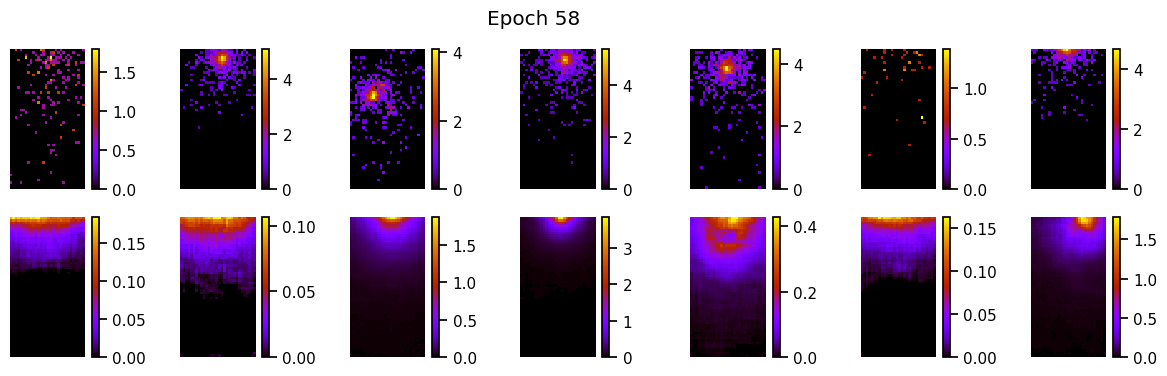

100/100 [==============================] - 0s 3ms/step
ws mean 33.23 ch1 25.09 ch2 54.70 ch3 0.89 ch4 0.86 ch5 84.61 Time for epoch 58 is 8.345359086990356 sec
5900 [Total loss: 64.40] [Recon_loss: 63.42] [KL loss: 1.40]


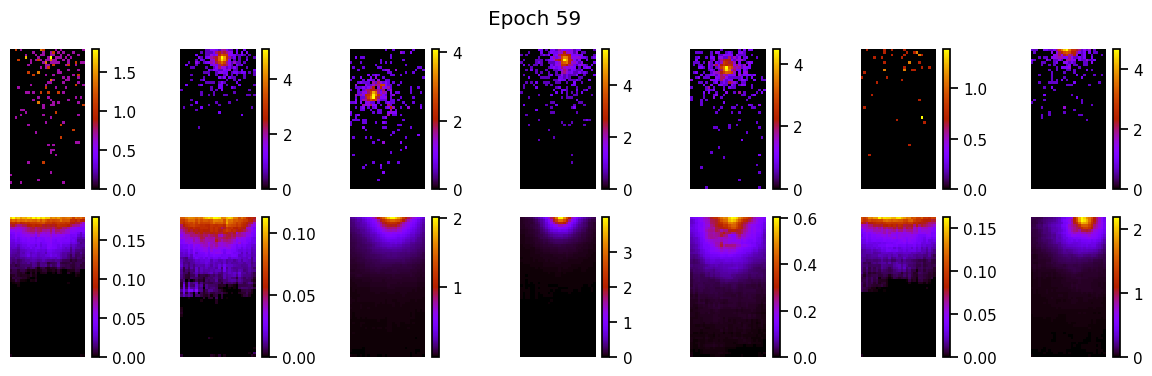

100/100 [==============================] - 0s 3ms/step
ws mean 24.72 ch1 20.46 ch2 38.99 ch3 0.72 ch4 0.73 ch5 62.71 Time for epoch 59 is 8.689102411270142 sec
6000 [Total loss: 56.03] [Recon_loss: 55.32] [KL loss: 1.01]


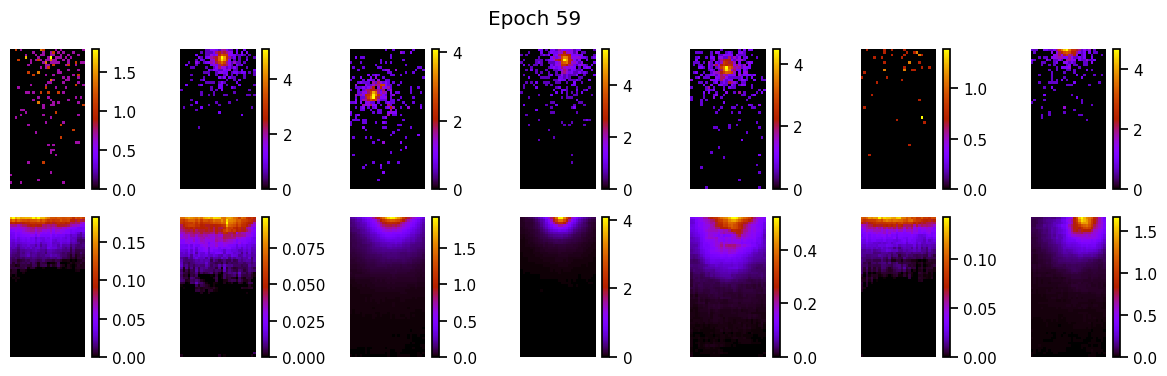

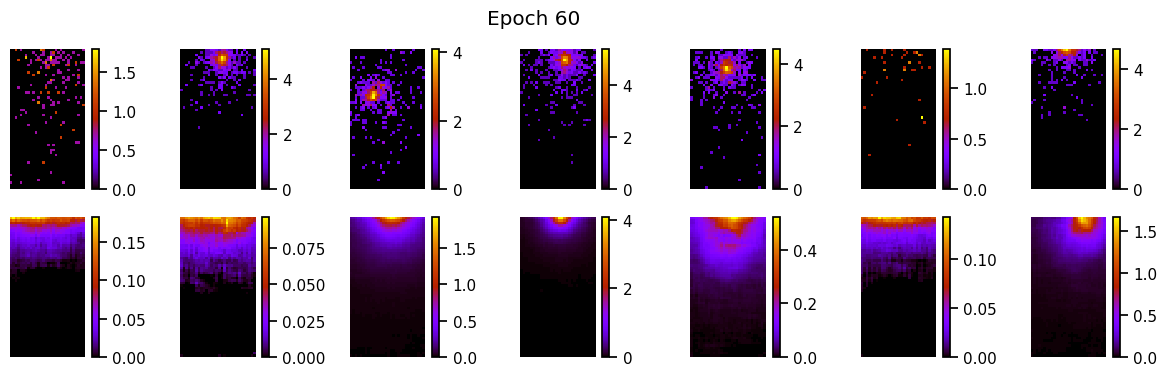

100/100 [==============================] - 0s 3ms/step
ws mean 33.31 ch1 24.70 ch2 54.90 ch3 1.06 ch4 1.02 ch5 84.89 Time for epoch 60 is 10.05610466003418 sec
6100 [Total loss: 61.51] [Recon_loss: 60.56] [KL loss: 1.35]


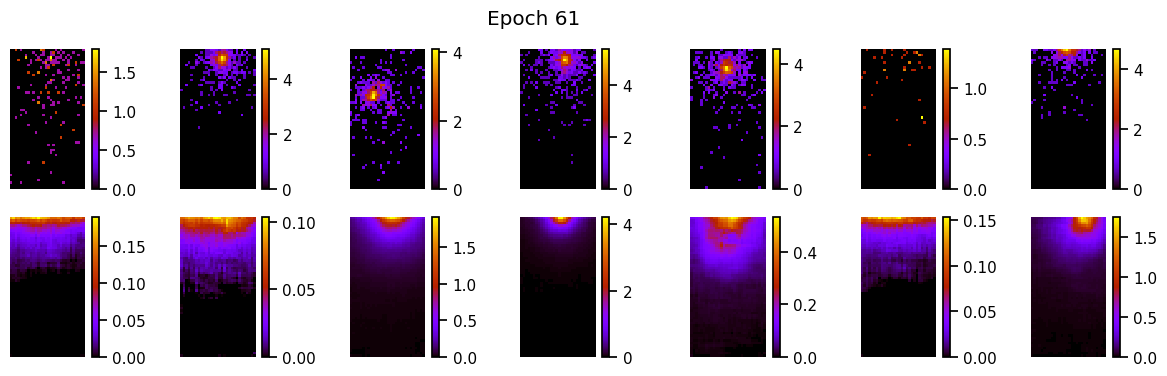

100/100 [==============================] - 0s 3ms/step
ws mean 26.08 ch1 20.80 ch2 41.72 ch3 0.86 ch4 0.85 ch5 66.17 Time for epoch 61 is 8.335676670074463 sec
6200 [Total loss: 56.91] [Recon_loss: 56.08] [KL loss: 1.19]


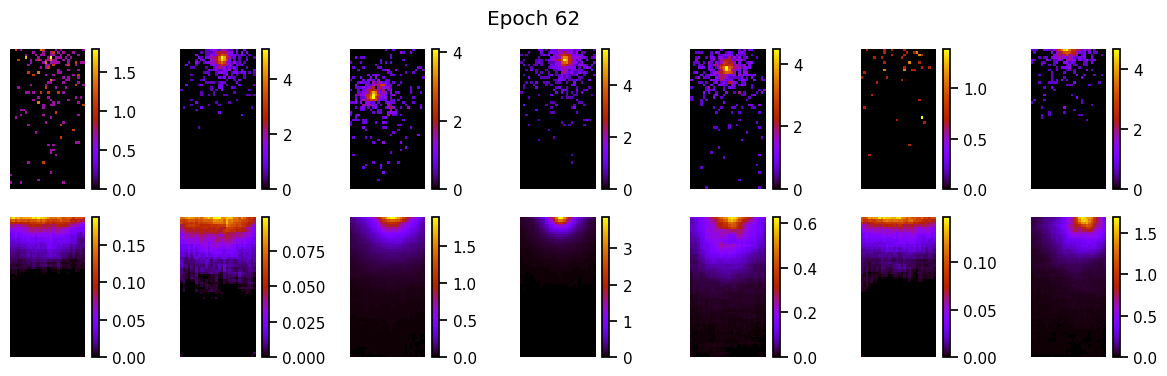

100/100 [==============================] - 0s 3ms/step
ws mean 32.67 ch1 26.40 ch2 51.91 ch3 0.91 ch4 0.91 ch5 83.23 Time for epoch 62 is 8.690603494644165 sec
6300 [Total loss: 52.35] [Recon_loss: 51.61] [KL loss: 1.06]


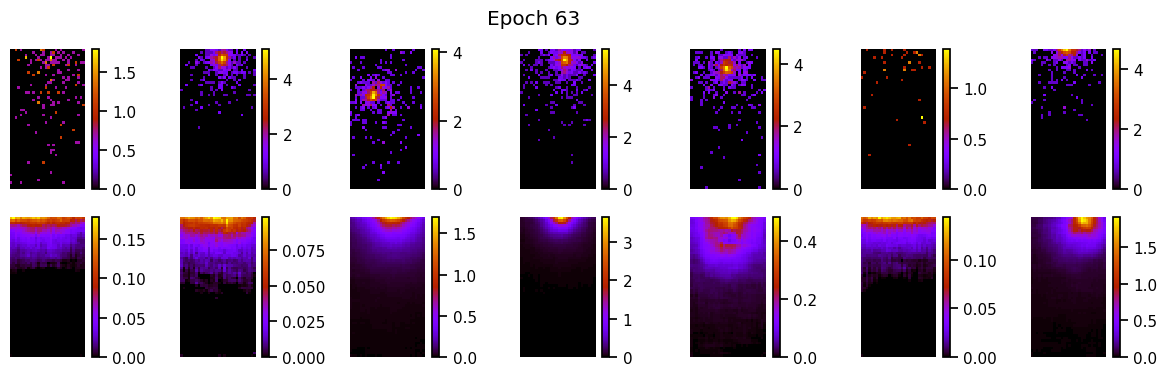

100/100 [==============================] - 0s 3ms/step
ws mean 35.43 ch1 26.55 ch2 58.35 ch3 0.97 ch4 0.93 ch5 90.32 Time for epoch 63 is 8.352516412734985 sec
6400 [Total loss: 61.95] [Recon_loss: 60.93] [KL loss: 1.45]


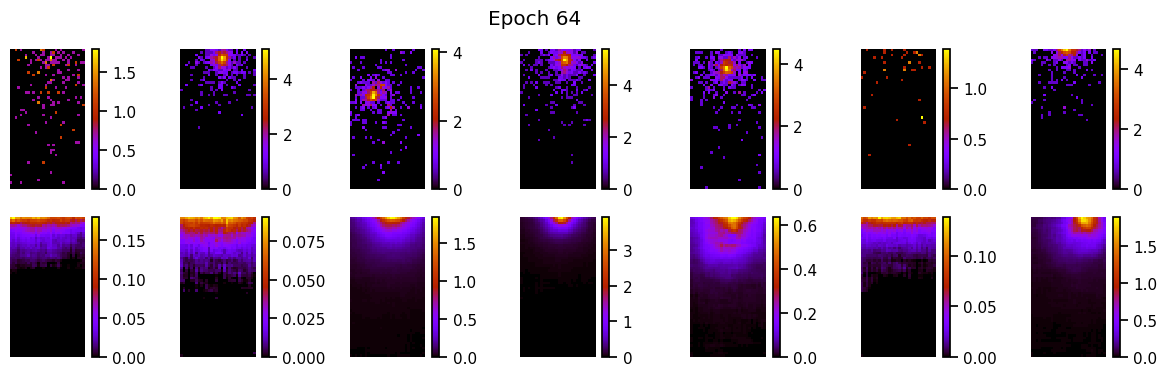

100/100 [==============================] - 0s 3ms/step
ws mean 31.83 ch1 25.66 ch2 50.23 ch3 1.02 ch4 1.05 ch5 81.19 Time for epoch 64 is 8.56575894355774 sec
6500 [Total loss: 59.93] [Recon_loss: 59.12] [KL loss: 1.16]


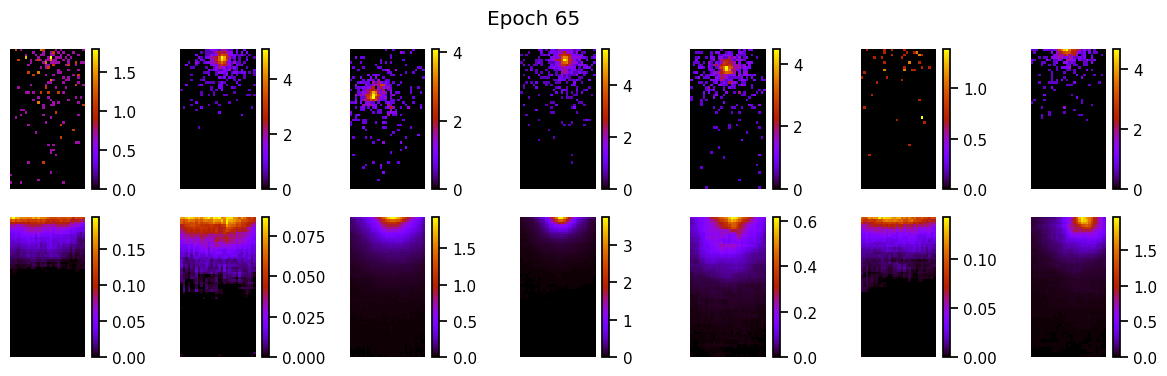

100/100 [==============================] - 0s 3ms/step
ws mean 30.51 ch1 24.39 ch2 48.64 ch3 0.93 ch4 0.92 ch5 77.69 Time for epoch 65 is 8.369248867034912 sec
6600 [Total loss: 58.79] [Recon_loss: 57.84] [KL loss: 1.36]


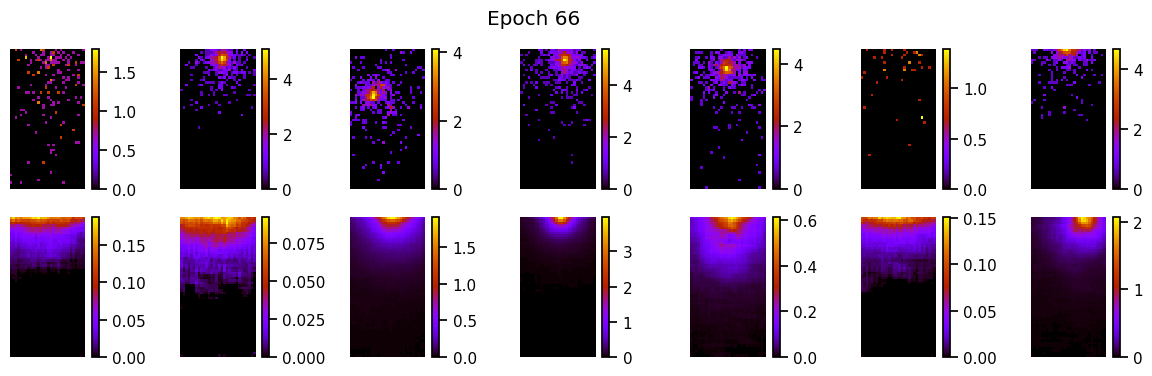

100/100 [==============================] - 0s 3ms/step
ws mean 29.78 ch1 23.90 ch2 47.58 ch3 0.85 ch4 0.87 ch5 75.72 Time for epoch 66 is 8.655065774917603 sec
6700 [Total loss: 62.73] [Recon_loss: 61.79] [KL loss: 1.33]


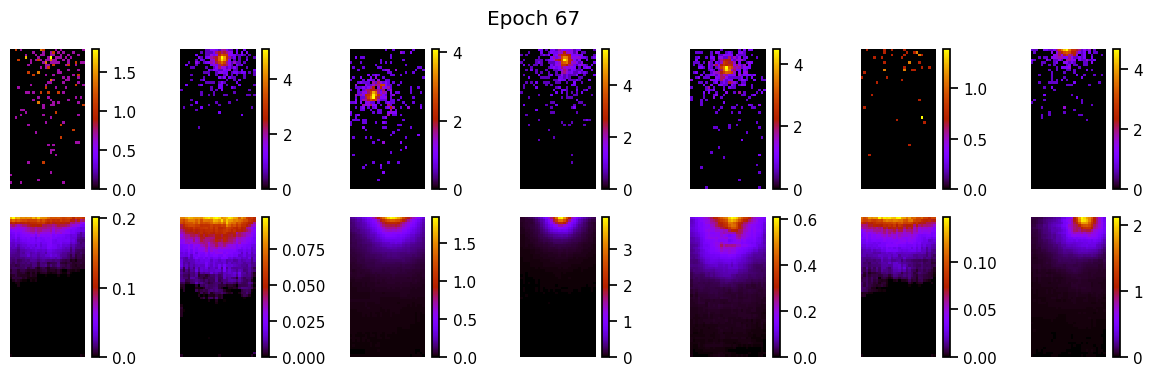

100/100 [==============================] - 0s 3ms/step
ws mean 28.55 ch1 22.63 ch2 46.13 ch3 0.79 ch4 0.75 ch5 72.43 Time for epoch 67 is 8.34894323348999 sec
6800 [Total loss: 60.08] [Recon_loss: 59.23] [KL loss: 1.23]


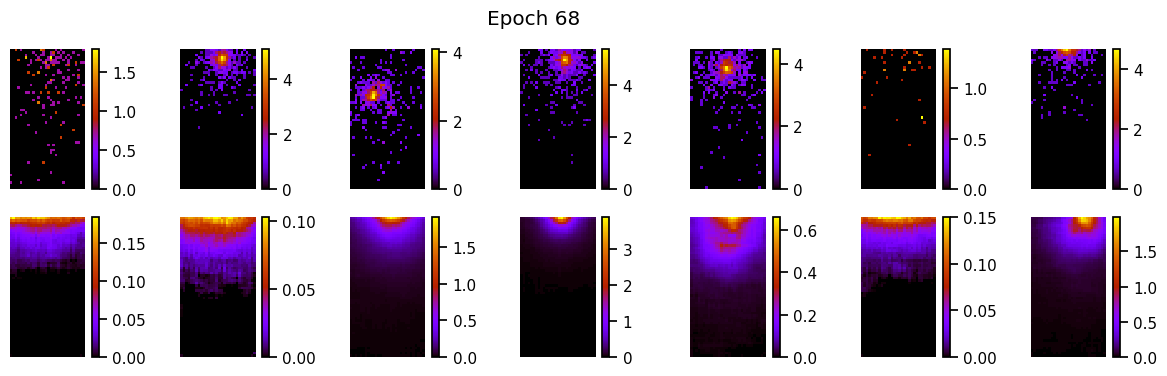

100/100 [==============================] - 0s 3ms/step
ws mean 28.09 ch1 21.57 ch2 45.79 ch3 0.86 ch4 0.81 ch5 71.44 Time for epoch 68 is 8.678067684173584 sec
6900 [Total loss: 53.69] [Recon_loss: 53.07] [KL loss: 0.88]


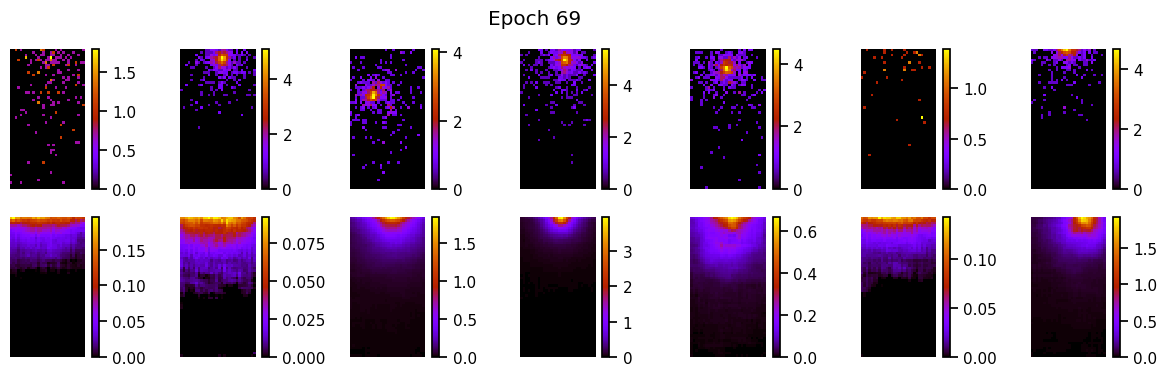

100/100 [==============================] - 0s 3ms/step
ws mean 31.90 ch1 25.05 ch2 51.46 ch3 0.90 ch4 0.84 ch5 81.26 Time for epoch 69 is 8.366602182388306 sec
7000 [Total loss: 63.64] [Recon_loss: 62.86] [KL loss: 1.11]


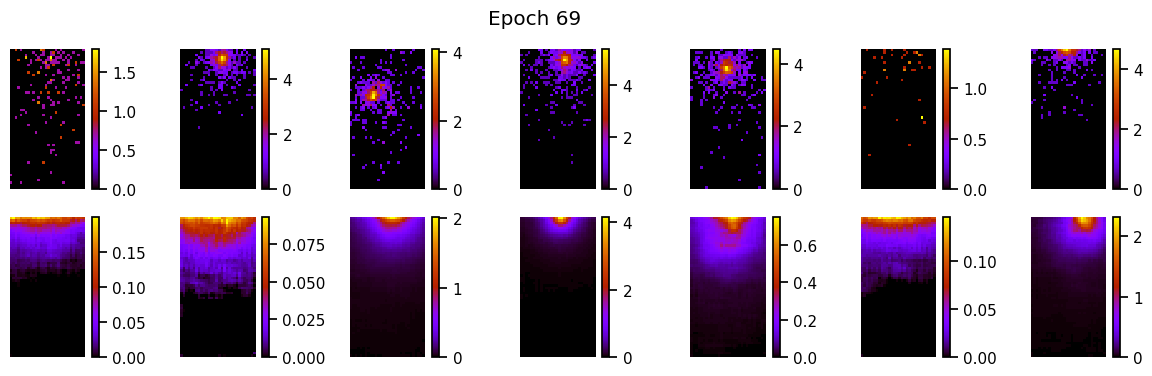

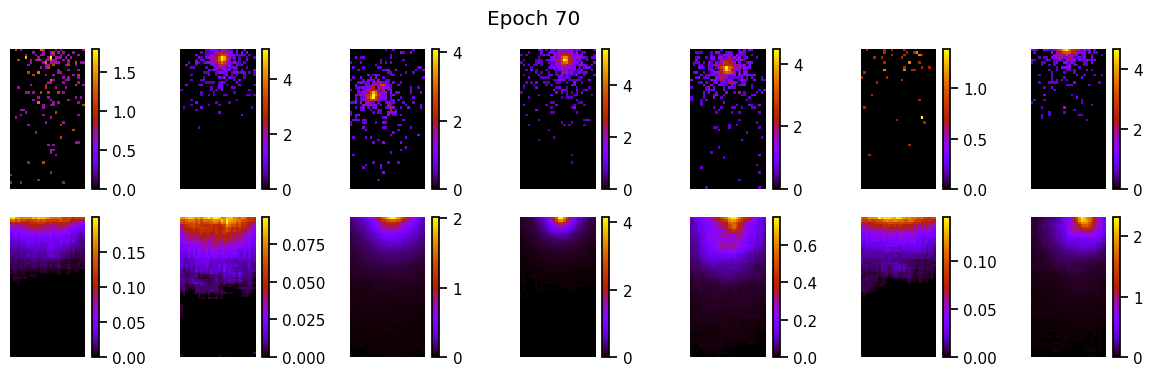

100/100 [==============================] - 0s 3ms/step
ws mean 24.36 ch1 19.85 ch2 38.60 ch3 0.78 ch4 0.79 ch5 61.79 Time for epoch 70 is 9.954755783081055 sec
7100 [Total loss: 57.81] [Recon_loss: 56.91] [KL loss: 1.27]


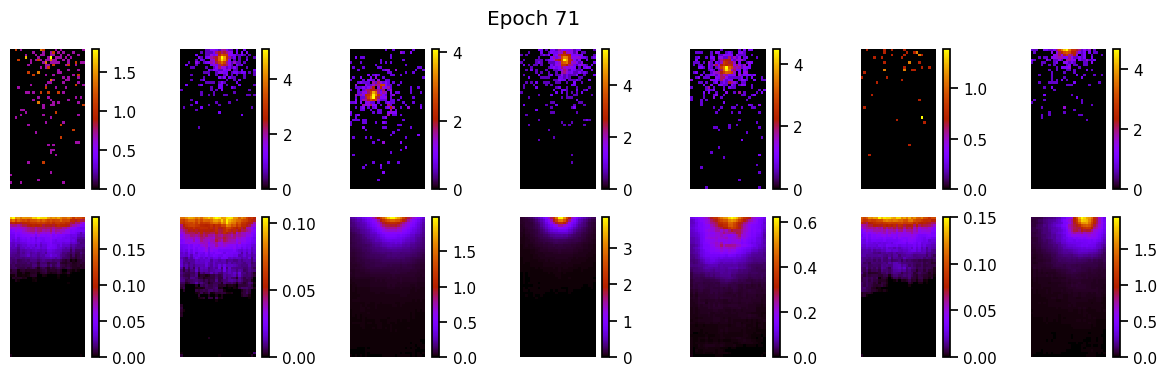

100/100 [==============================] - 0s 3ms/step
ws mean 27.69 ch1 22.08 ch2 44.27 ch3 0.86 ch4 0.84 ch5 70.41 Time for epoch 71 is 8.611140489578247 sec
7200 [Total loss: 62.70] [Recon_loss: 61.83] [KL loss: 1.23]


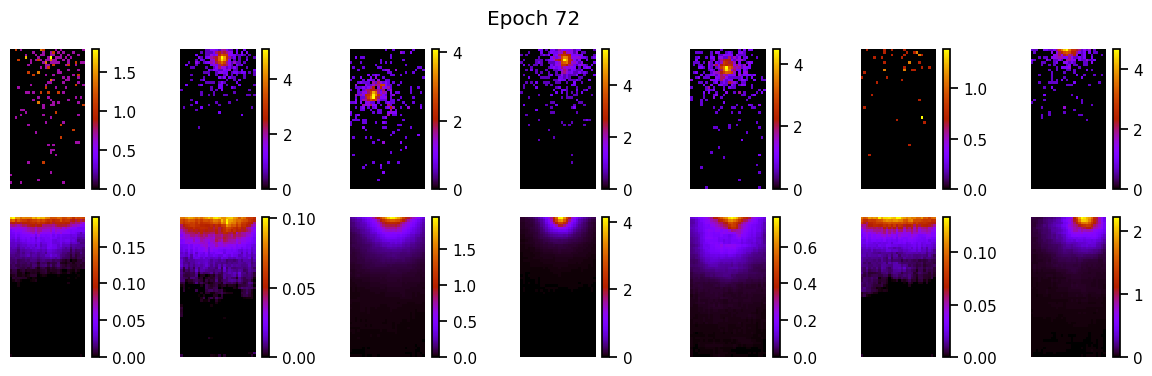

100/100 [==============================] - 0s 3ms/step
ws mean 25.28 ch1 19.96 ch2 40.86 ch3 0.79 ch4 0.77 ch5 64.01 Time for epoch 72 is 8.287954330444336 sec
7300 [Total loss: 61.11] [Recon_loss: 60.31] [KL loss: 1.15]


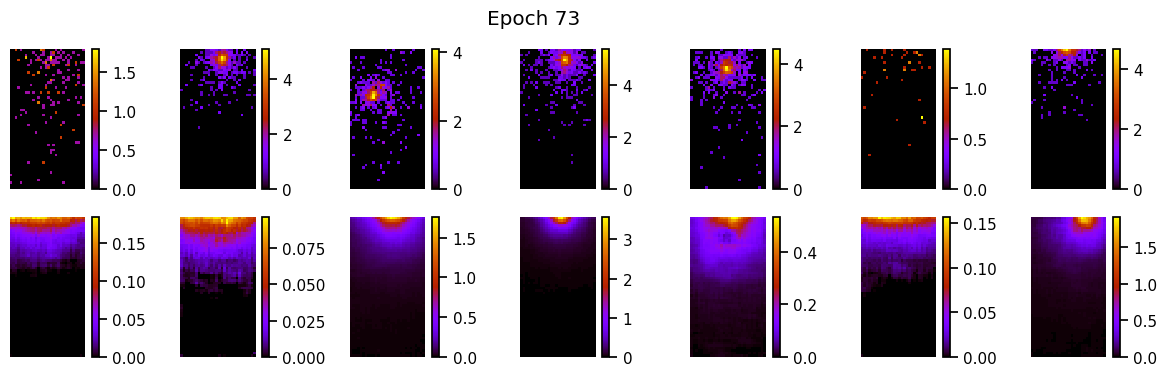

100/100 [==============================] - 0s 3ms/step
ws mean 33.01 ch1 24.85 ch2 54.30 ch3 0.96 ch4 0.96 ch5 84.00 Time for epoch 73 is 8.826544523239136 sec
7400 [Total loss: 57.02] [Recon_loss: 56.48] [KL loss: 0.77]


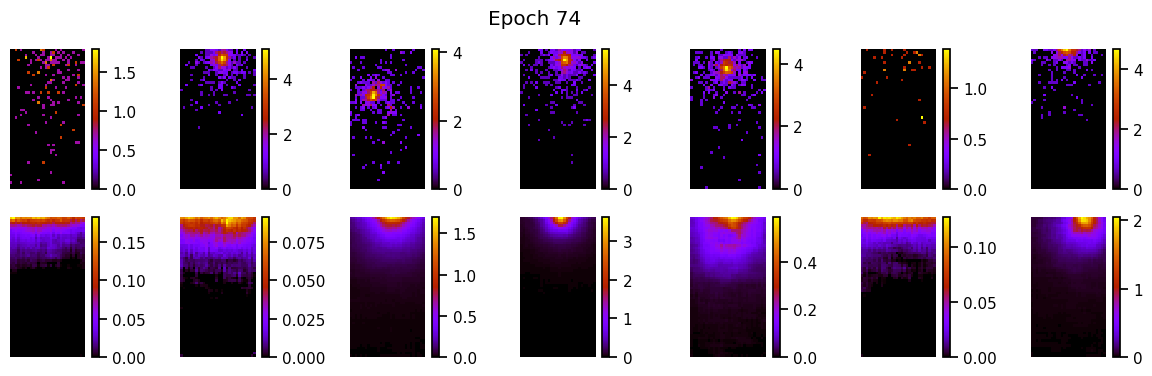

100/100 [==============================] - 0s 3ms/step
ws mean 33.19 ch1 25.72 ch2 53.49 ch3 1.09 ch4 1.02 ch5 84.64 Time for epoch 74 is 8.310770034790039 sec
7500 [Total loss: 61.81] [Recon_loss: 60.88] [KL loss: 1.34]


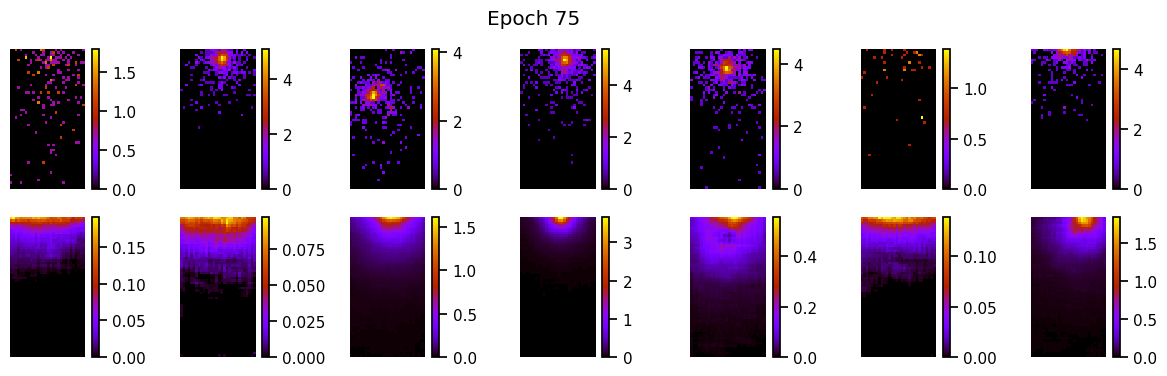

100/100 [==============================] - 0s 3ms/step
ws mean 32.94 ch1 25.75 ch2 53.23 ch3 0.98 ch4 0.96 ch5 83.80 Time for epoch 75 is 8.492318391799927 sec
7600 [Total loss: 69.87] [Recon_loss: 68.94] [KL loss: 1.33]


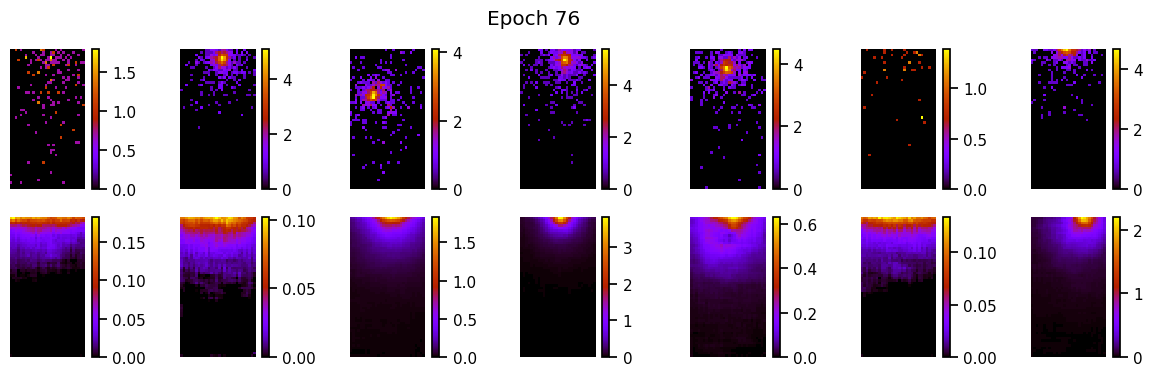

100/100 [==============================] - 0s 3ms/step
ws mean 29.15 ch1 22.54 ch2 47.47 ch3 0.85 ch4 0.82 ch5 74.07 Time for epoch 76 is 8.297658920288086 sec
7700 [Total loss: 61.04] [Recon_loss: 60.26] [KL loss: 1.11]


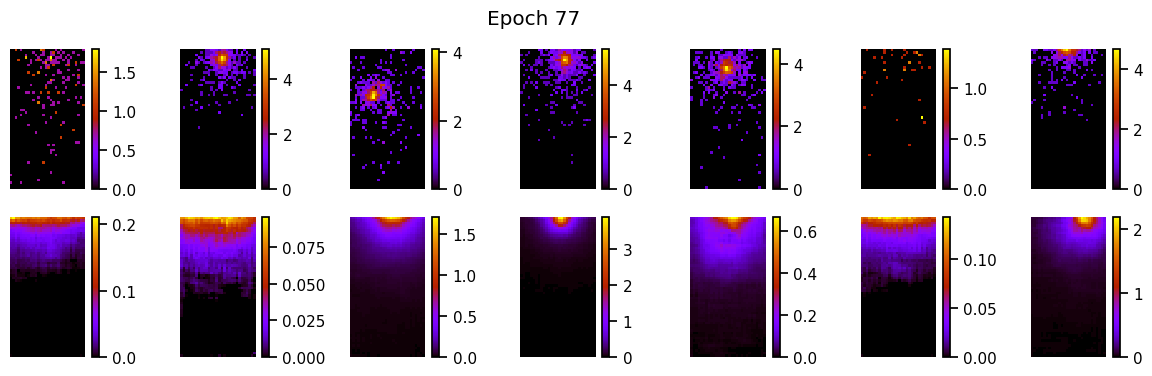

100/100 [==============================] - 0s 3ms/step
ws mean 27.90 ch1 21.66 ch2 45.42 ch3 0.87 ch4 0.82 ch5 70.71 Time for epoch 77 is 8.569266319274902 sec
7800 [Total loss: 58.32] [Recon_loss: 57.52] [KL loss: 1.14]


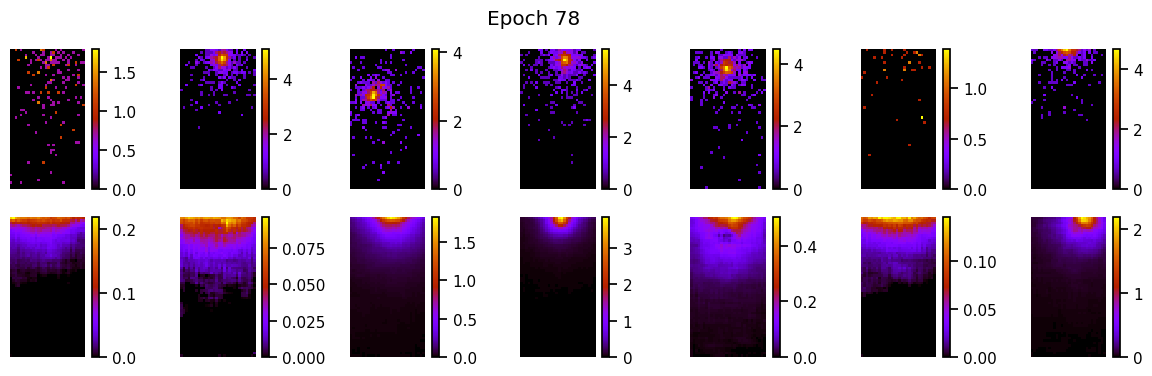

100/100 [==============================] - 0s 3ms/step
ws mean 29.39 ch1 23.11 ch2 47.49 ch3 0.86 ch4 0.87 ch5 74.59 Time for epoch 78 is 8.301035404205322 sec
7900 [Total loss: 55.24] [Recon_loss: 54.44] [KL loss: 1.14]


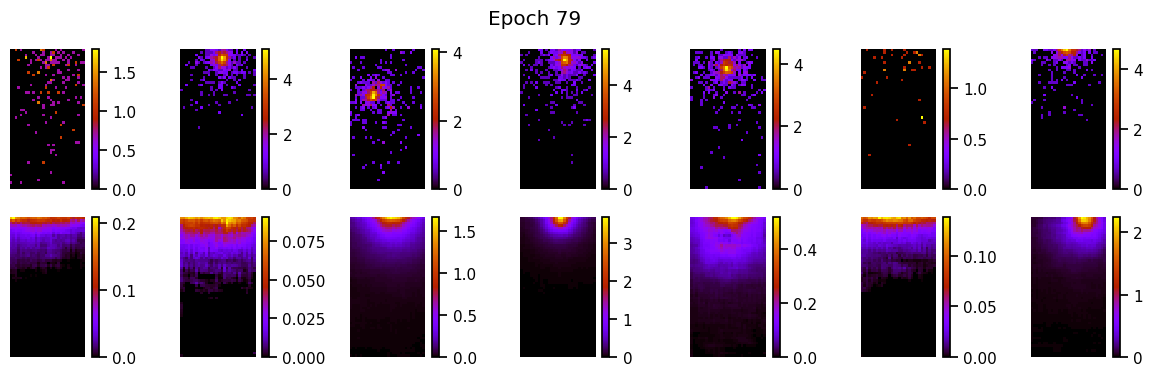

100/100 [==============================] - 0s 3ms/step
ws mean 31.51 ch1 24.26 ch2 50.94 ch3 1.09 ch4 1.06 ch5 80.18 Time for epoch 79 is 8.581466674804688 sec
8000 [Total loss: 54.47] [Recon_loss: 53.75] [KL loss: 1.02]


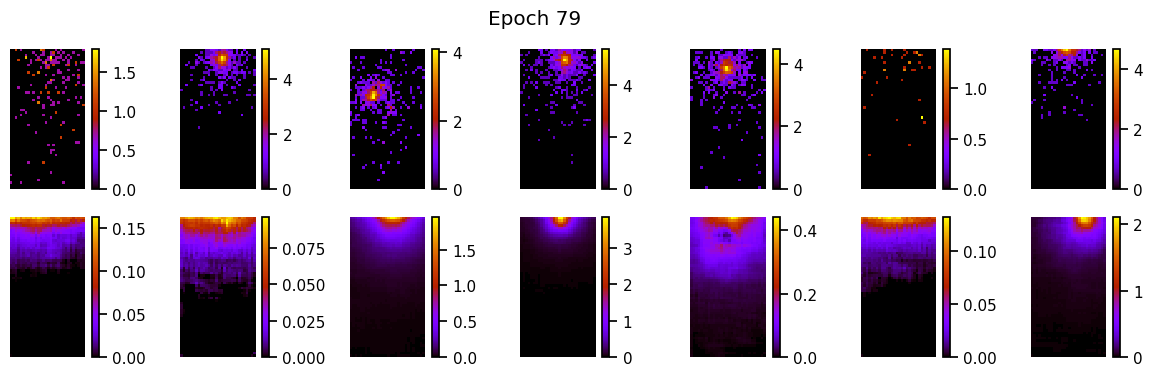

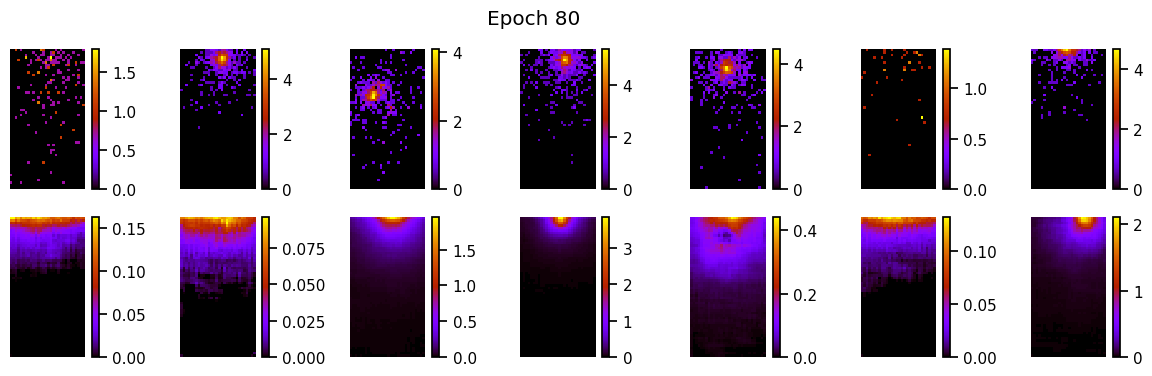

100/100 [==============================] - 0s 3ms/step
ws mean 25.96 ch1 21.51 ch2 40.19 ch3 1.02 ch4 0.98 ch5 66.07 Time for epoch 80 is 9.906452894210815 sec
8100 [Total loss: 55.45] [Recon_loss: 54.71] [KL loss: 1.05]


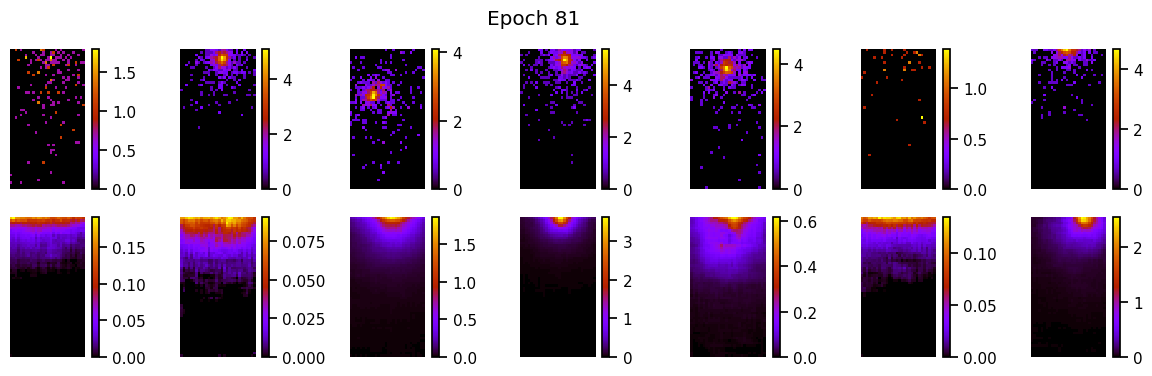

100/100 [==============================] - 0s 3ms/step
ws mean 29.01 ch1 23.09 ch2 46.27 ch3 0.97 ch4 0.92 ch5 73.80 Time for epoch 81 is 8.307581663131714 sec
8200 [Total loss: 62.75] [Recon_loss: 61.94] [KL loss: 1.15]


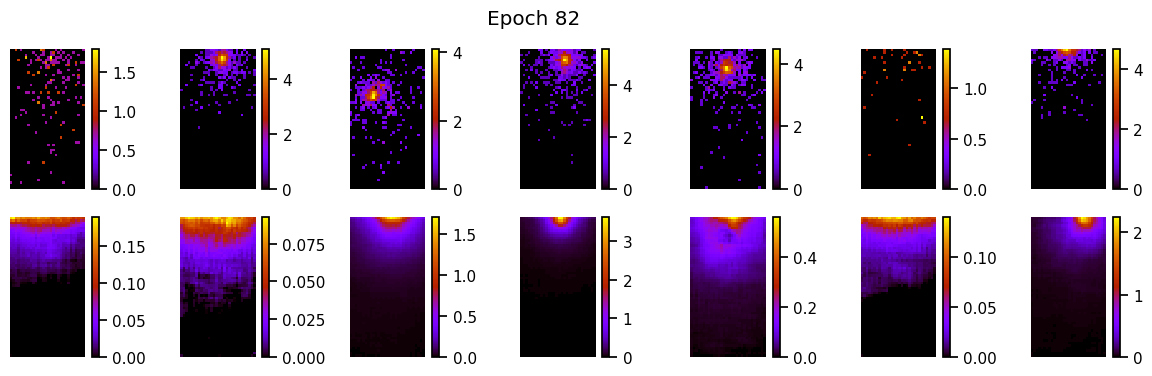

100/100 [==============================] - 0s 3ms/step
ws mean 31.65 ch1 24.67 ch2 51.59 ch3 0.87 ch4 0.82 ch5 80.31 Time for epoch 82 is 8.557122468948364 sec
8300 [Total loss: 64.18] [Recon_loss: 63.24] [KL loss: 1.33]


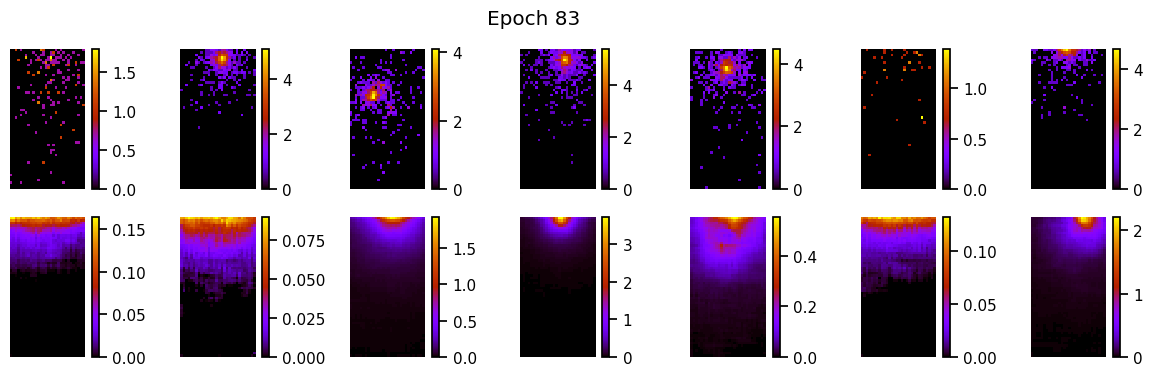

100/100 [==============================] - 0s 3ms/step
ws mean 26.46 ch1 22.97 ch2 40.30 ch3 0.99 ch4 0.93 ch5 67.14 Time for epoch 83 is 8.294684648513794 sec
8400 [Total loss: 49.93] [Recon_loss: 49.51] [KL loss: 0.61]


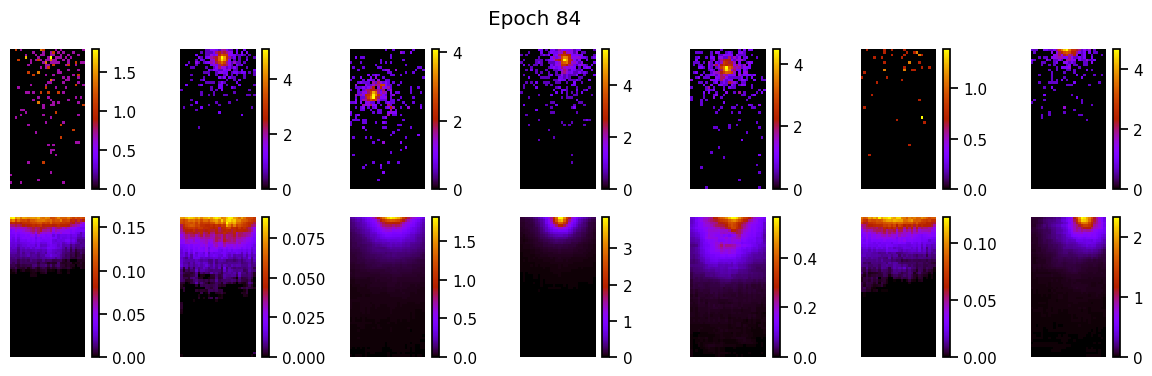

100/100 [==============================] - 0s 3ms/step
ws mean 27.48 ch1 23.13 ch2 42.54 ch3 1.01 ch4 1.00 ch5 69.72 Time for epoch 84 is 8.624155044555664 sec
8500 [Total loss: 64.04] [Recon_loss: 63.08] [KL loss: 1.37]


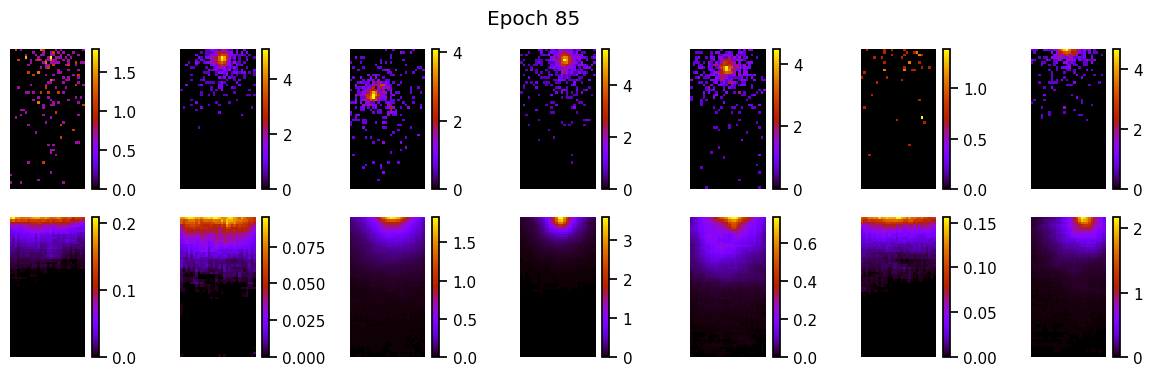

100/100 [==============================] - 0s 3ms/step
ws mean 27.38 ch1 22.75 ch2 42.55 ch3 1.06 ch4 0.97 ch5 69.55 Time for epoch 85 is 8.274070024490356 sec
8600 [Total loss: 56.49] [Recon_loss: 55.90] [KL loss: 0.83]


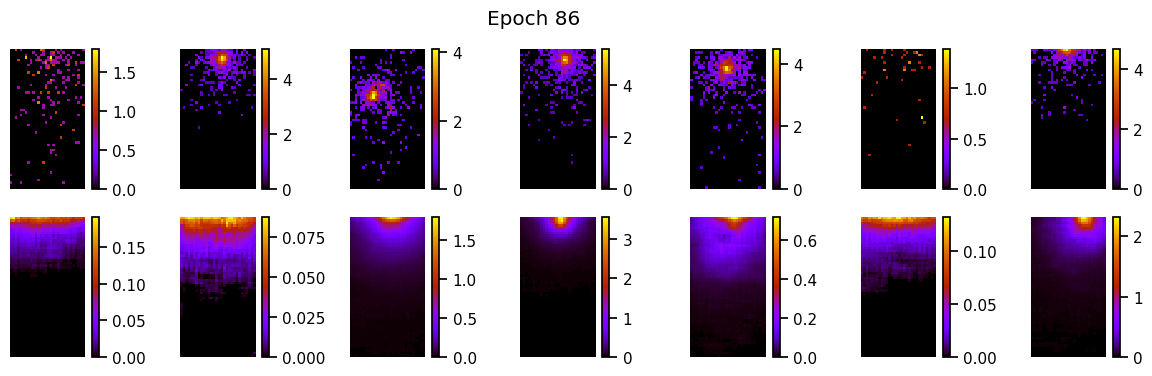

100/100 [==============================] - 0s 3ms/step
ws mean 28.38 ch1 22.88 ch2 44.92 ch3 1.08 ch4 1.04 ch5 71.96 Time for epoch 86 is 8.646807432174683 sec
8700 [Total loss: 57.69] [Recon_loss: 57.00] [KL loss: 0.98]


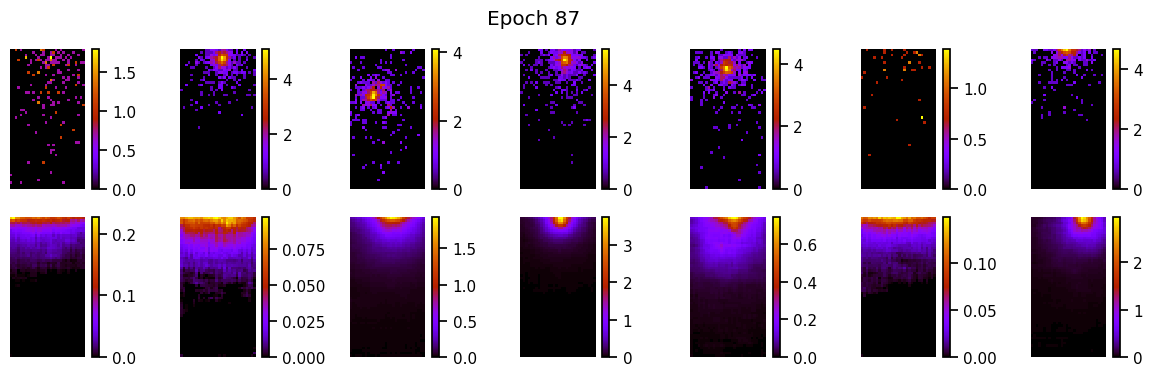

100/100 [==============================] - 0s 3ms/step
ws mean 22.43 ch1 19.23 ch2 34.14 ch3 0.97 ch4 0.94 ch5 56.85 Time for epoch 87 is 8.355782985687256 sec
8800 [Total loss: 61.69] [Recon_loss: 60.85] [KL loss: 1.20]


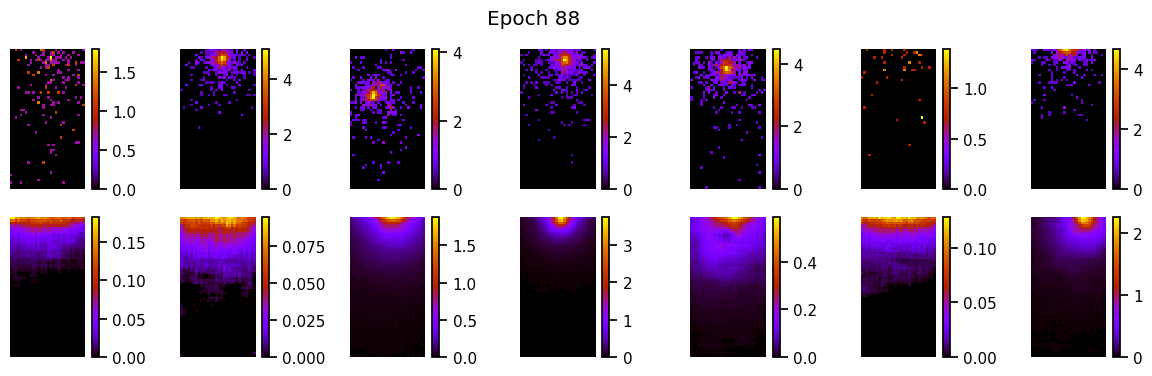

100/100 [==============================] - 0s 3ms/step
ws mean 26.92 ch1 22.40 ch2 41.96 ch3 0.96 ch4 0.93 ch5 68.36 Time for epoch 88 is 8.670222997665405 sec
8900 [Total loss: 66.19] [Recon_loss: 65.17] [KL loss: 1.46]


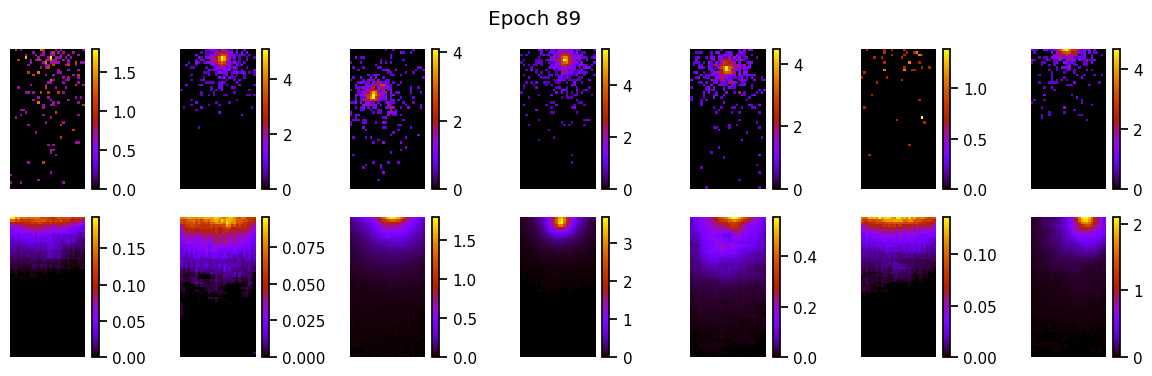

100/100 [==============================] - 0s 3ms/step
ws mean 30.32 ch1 24.22 ch2 48.47 ch3 0.98 ch4 0.97 ch5 76.98 Time for epoch 89 is 8.376627683639526 sec
9000 [Total loss: 56.68] [Recon_loss: 56.21] [KL loss: 0.67]


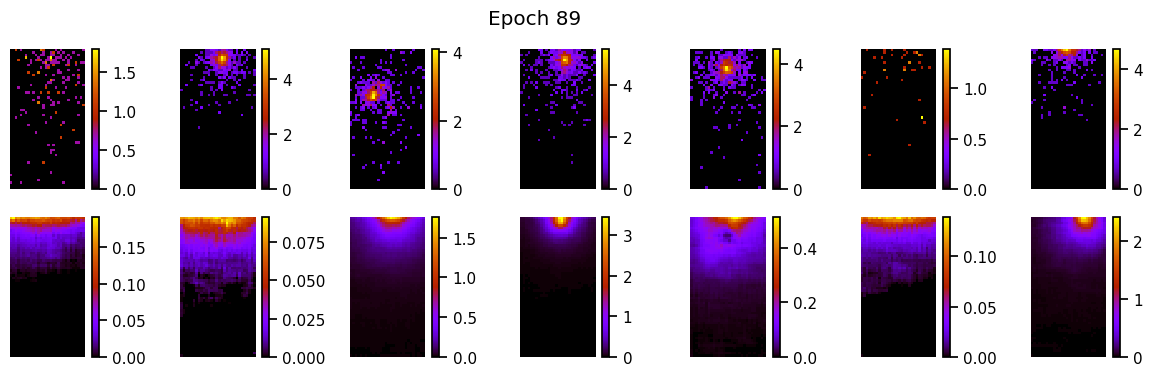

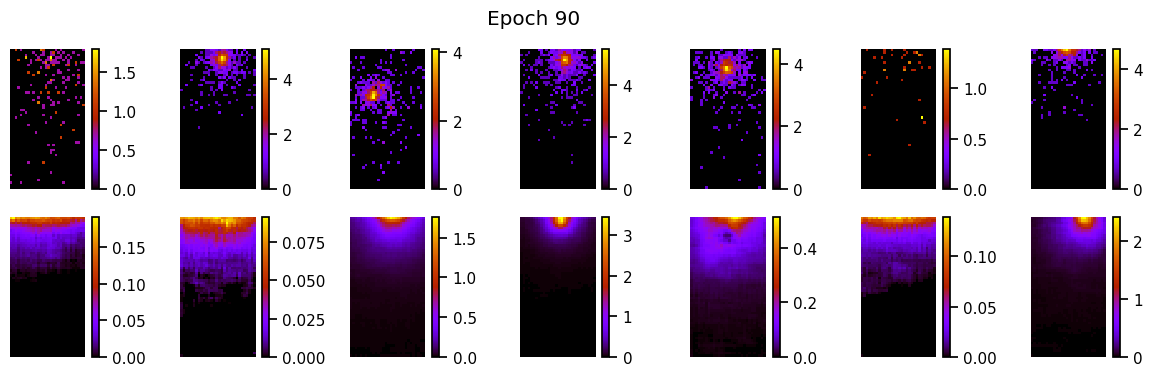

100/100 [==============================] - 0s 3ms/step
ws mean 30.06 ch1 24.08 ch2 47.73 ch3 1.06 ch4 1.02 ch5 76.41 Time for epoch 90 is 10.119391202926636 sec
9100 [Total loss: 60.58] [Recon_loss: 59.76] [KL loss: 1.17]


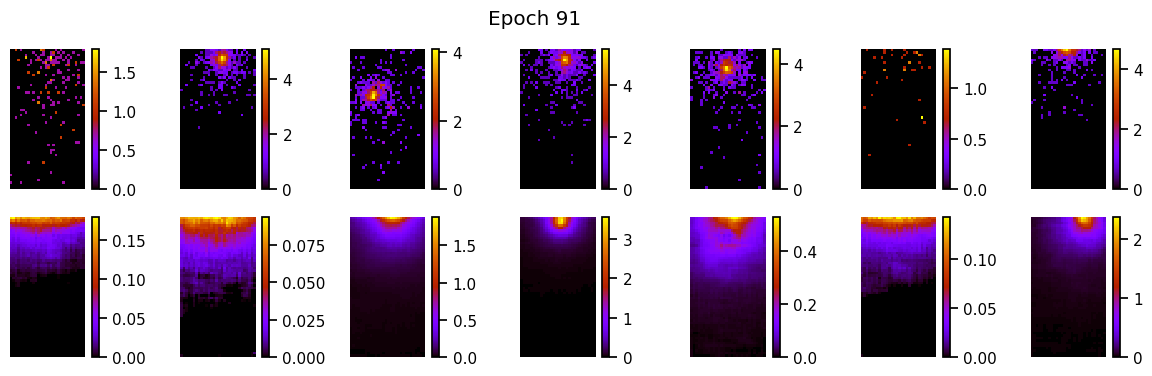

100/100 [==============================] - 0s 3ms/step
ws mean 25.55 ch1 20.29 ch2 40.98 ch3 0.89 ch4 0.84 ch5 64.73 Time for epoch 91 is 8.72852087020874 sec
9200 [Total loss: 59.52] [Recon_loss: 58.82] [KL loss: 1.01]


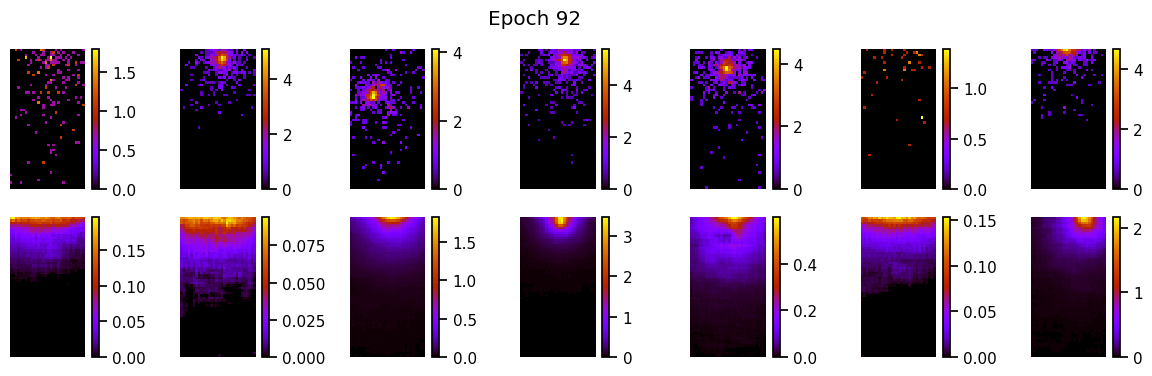

100/100 [==============================] - 0s 3ms/step
ws mean 26.76 ch1 21.83 ch2 42.33 ch3 0.94 ch4 0.92 ch5 67.81 Time for epoch 92 is 8.425168752670288 sec
9300 [Total loss: 66.41] [Recon_loss: 65.41] [KL loss: 1.42]


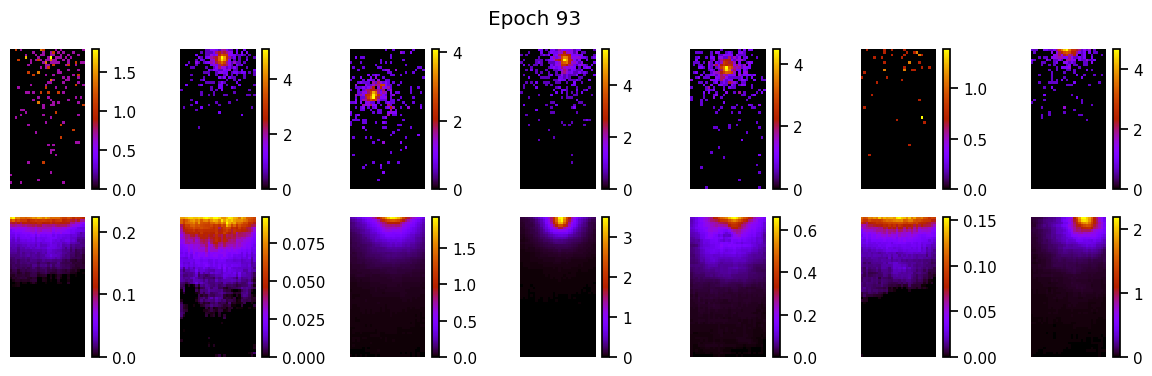

100/100 [==============================] - 0s 3ms/step
ws mean 21.19 ch1 17.95 ch2 33.22 ch3 0.78 ch4 0.73 ch5 53.26 Time for epoch 93 is 8.781952619552612 sec
9400 [Total loss: 51.61] [Recon_loss: 51.14] [KL loss: 0.67]


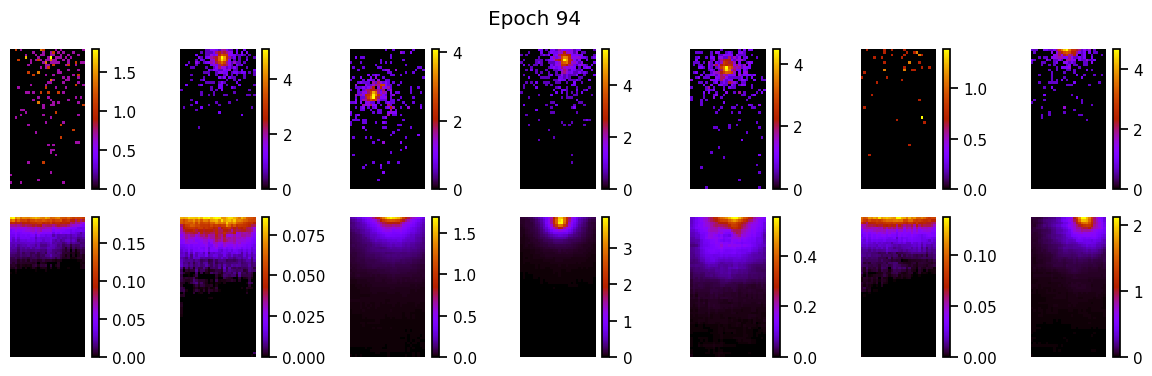

100/100 [==============================] - 0s 3ms/step
ws mean 26.39 ch1 21.52 ch2 41.30 ch3 1.22 ch4 1.16 ch5 66.77 Time for epoch 94 is 8.475086450576782 sec
9500 [Total loss: 51.80] [Recon_loss: 51.23] [KL loss: 0.81]


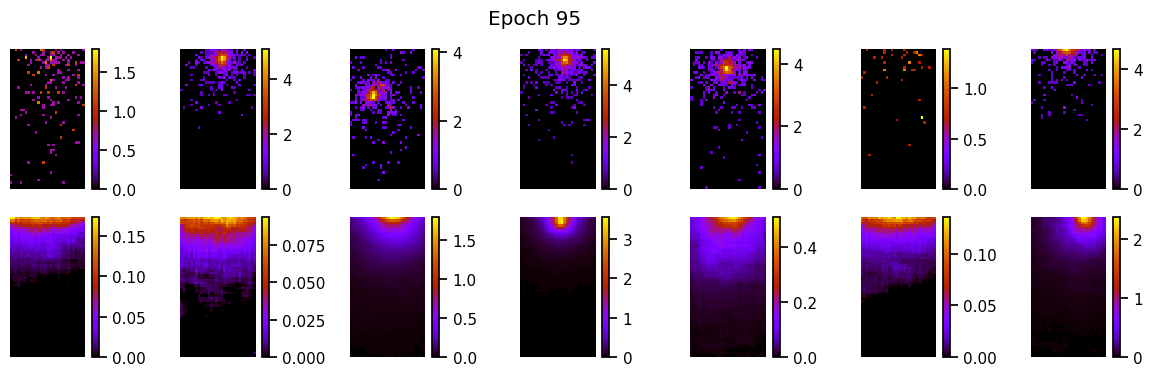

100/100 [==============================] - 0s 3ms/step
ws mean 27.65 ch1 22.97 ch2 43.26 ch3 0.95 ch4 0.93 ch5 70.13 Time for epoch 95 is 8.84041428565979 sec
9600 [Total loss: 50.09] [Recon_loss: 49.67] [KL loss: 0.60]


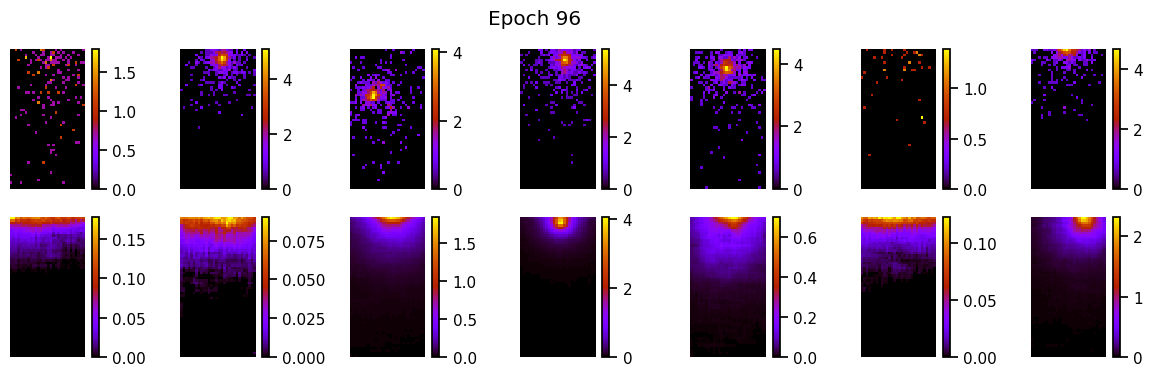

100/100 [==============================] - 0s 3ms/step
ws mean 24.72 ch1 20.71 ch2 37.84 ch3 1.24 ch4 1.21 ch5 62.58 Time for epoch 96 is 8.521020412445068 sec
9700 [Total loss: 54.99] [Recon_loss: 54.25] [KL loss: 1.05]


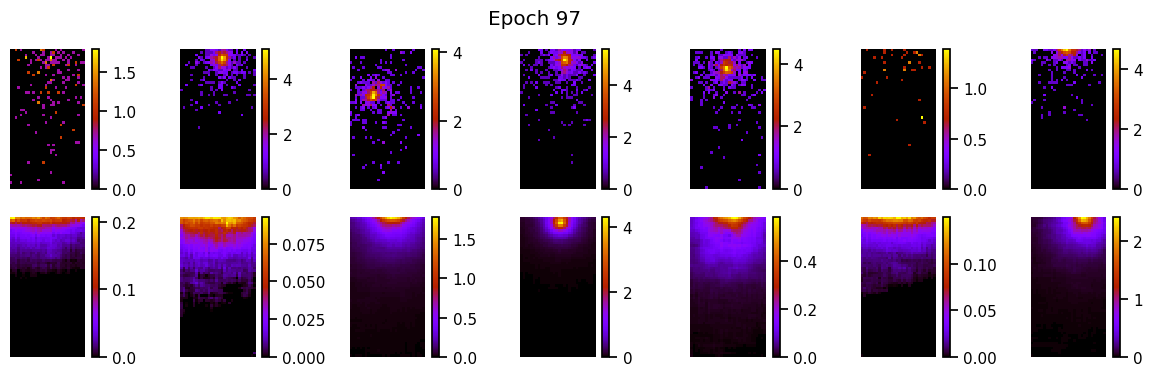

100/100 [==============================] - 0s 4ms/step
ws mean 23.87 ch1 19.68 ch2 37.32 ch3 0.98 ch4 0.95 ch5 60.42 Time for epoch 97 is 8.898595333099365 sec
9800 [Total loss: 62.28] [Recon_loss: 61.32] [KL loss: 1.36]


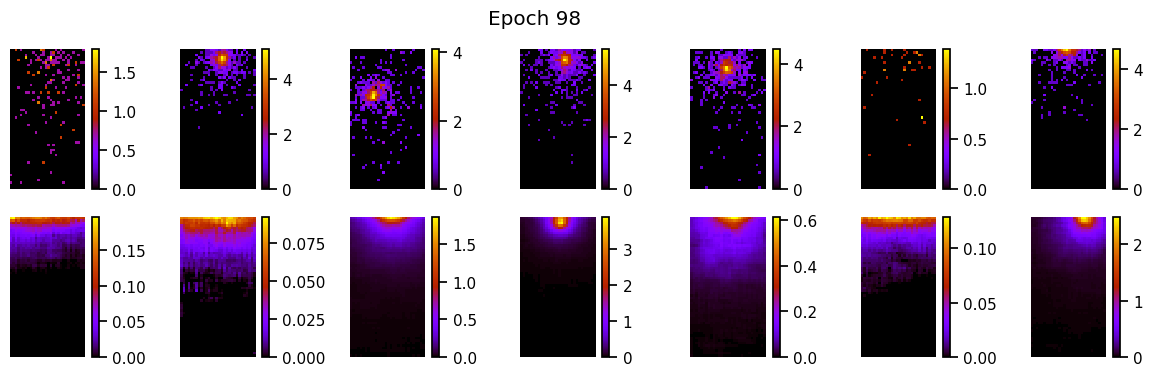

100/100 [==============================] - 0s 4ms/step
ws mean 27.17 ch1 21.77 ch2 42.93 ch3 1.15 ch4 1.12 ch5 68.86 Time for epoch 98 is 8.58955430984497 sec
9900 [Total loss: 58.45] [Recon_loss: 57.89] [KL loss: 0.79]


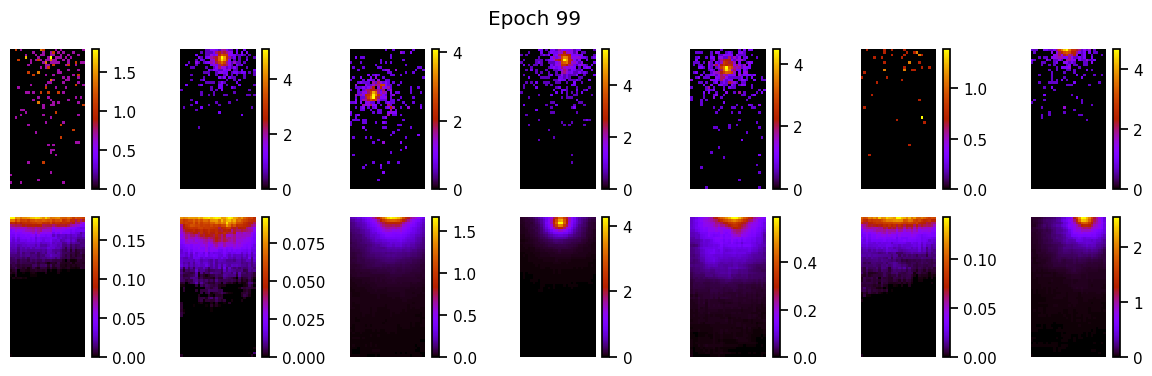

100/100 [==============================] - 0s 4ms/step
ws mean 24.49 ch1 20.72 ch2 37.71 ch3 1.00 ch4 0.96 ch5 62.04 Time for epoch 99 is 8.84723949432373 sec
10000 [Total loss: 54.43] [Recon_loss: 53.80] [KL loss: 0.90]


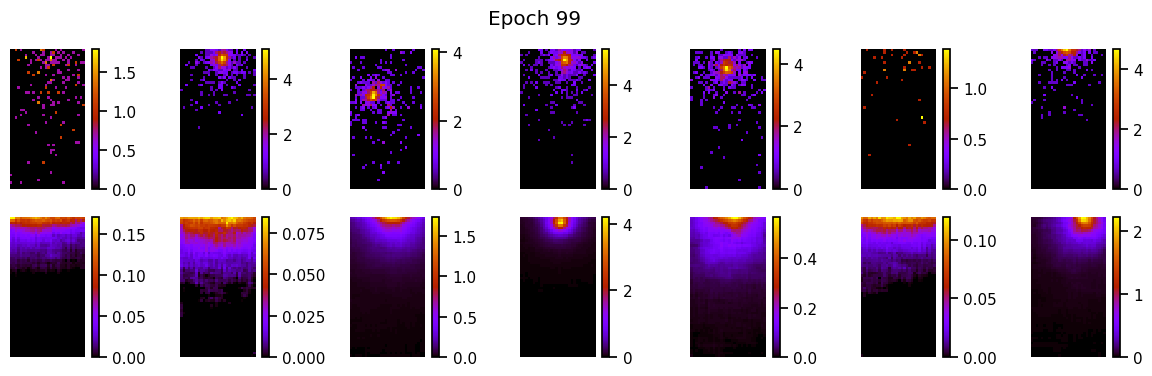

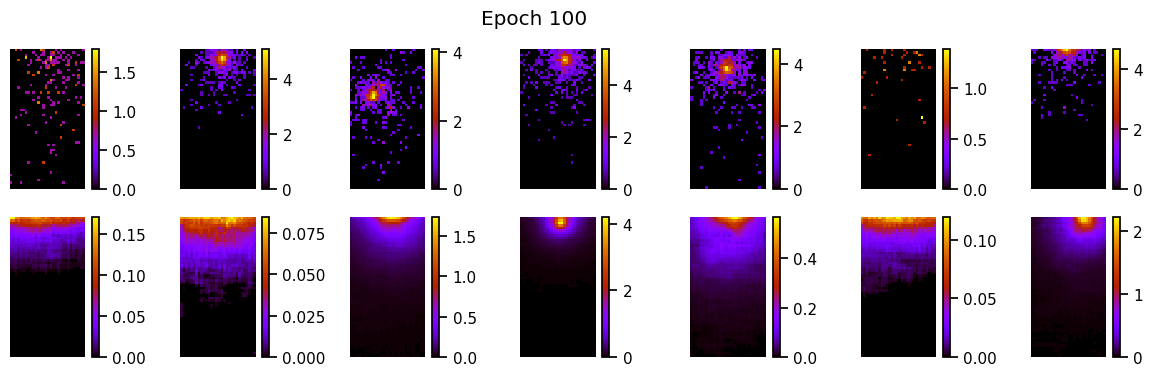

100/100 [==============================] - 0s 4ms/step
ws mean 24.76 ch1 21.06 ch2 37.93 ch3 1.03 ch4 1.01 ch5 62.75 Time for epoch 100 is 10.2585768699646 sec
10100 [Total loss: 50.06] [Recon_loss: 49.63] [KL loss: 0.61]


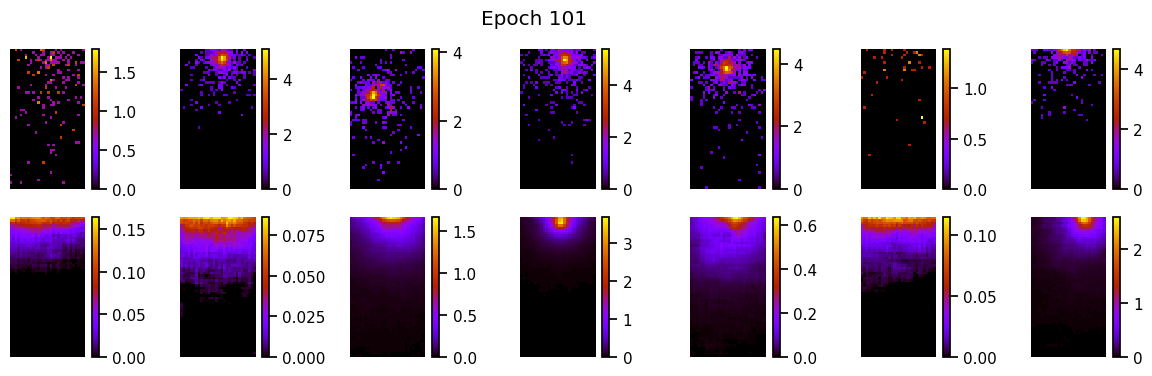

100/100 [==============================] - 0s 4ms/step
ws mean 27.44 ch1 22.71 ch2 42.61 ch3 1.16 ch4 1.09 ch5 69.64 Time for epoch 101 is 8.596732139587402 sec


In [39]:
def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n,score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")



####################### training ##############################
@tf.function
def train_step(batch,step):

    images, cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]

    #train vae
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder([images, cond])
        reconstruction = generator([z, cond])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(tf.reshape(images,(-1,56,30,1)), reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = 0.7 * kl_loss + reconstruction_loss
        # total_loss = reconstruction_loss
    grads = tape.gradient(total_loss, generator.trainable_weights+encoder.trainable_weights)
    vae_optimizer.apply_gradients(zip(grads, generator.trainable_weights+encoder.trainable_weights))

    return total_loss, reconstruction_loss, kl_loss


history = []
history_loss = []
def train(dataset, epochs):
    tf_step =tf.Variable(0, dtype=float)
    step=0
    generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])
    #print(calculate_ws_mae(3))
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            total_loss, reconstruction_loss, kl_loss =train_step(batch,tf_step)
            history.append([total_loss, reconstruction_loss, kl_loss])
            tf_step.assign_add(1)
            step = step+1

            if step%100==0:
                print("%d [Total loss: %.2f] [Recon_loss: %.2f] [KL loss: %.2f]"% (
                    step, total_loss, reconstruction_loss, kl_loss))

            if step%1000==0:
                generate_and_save_images(generator,
                               epoch,
                               [seed, seed_cond])

        generate_and_save_images(generator,
                                 epoch + 1,
                                 [seed, seed_cond]
                                 )

        # # Save the model every epoch
        # encoder.save_weights("../models/enc_"+NAME + "_"+ str(epoch) +".h5")
        # generator.save_weights("../models/gen_"+NAME + "_"+ str(epoch) +".h5")
        # np.savez("../models/history_"+NAME+".npz",np.array(history))
        calculate_ws_ch(min(epoch//5+1,5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history


def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig, axs = plt.subplots(2, 7, figsize=(15, 4))
    fig.suptitle(f"Epoch {epoch}")
    for i in range(0, 14):
        if i < 7:
            x = x_test[20 + i].reshape(56, 30)
        else:
            x = predictions[i - 7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, interpolation='none', cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])
    plt.savefig('../images/proton_photonsum_30/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# ### Train model
history=train(dataset_with_cond, EPOCHS)

## Visualize losses

In [40]:
import seaborn as sns

sns.set_context('notebook', font_scale = 1)

In [41]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [42]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [43]:
a4_dims = (14, 5)
def print_loss(loss_values, loss_str):
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")
    plt.savefig(f"../images/proton_photonsum_30/{loss_str}_loss")

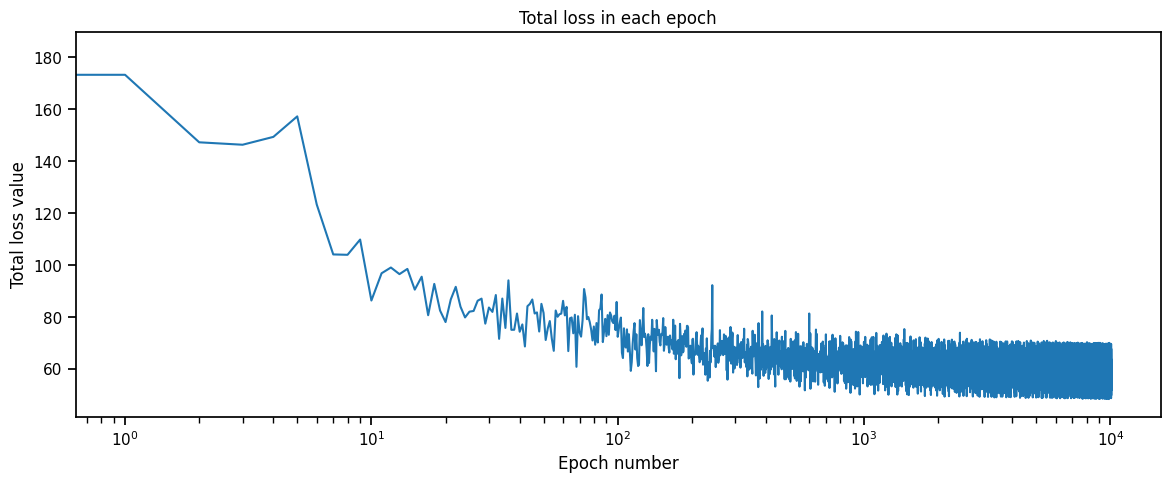

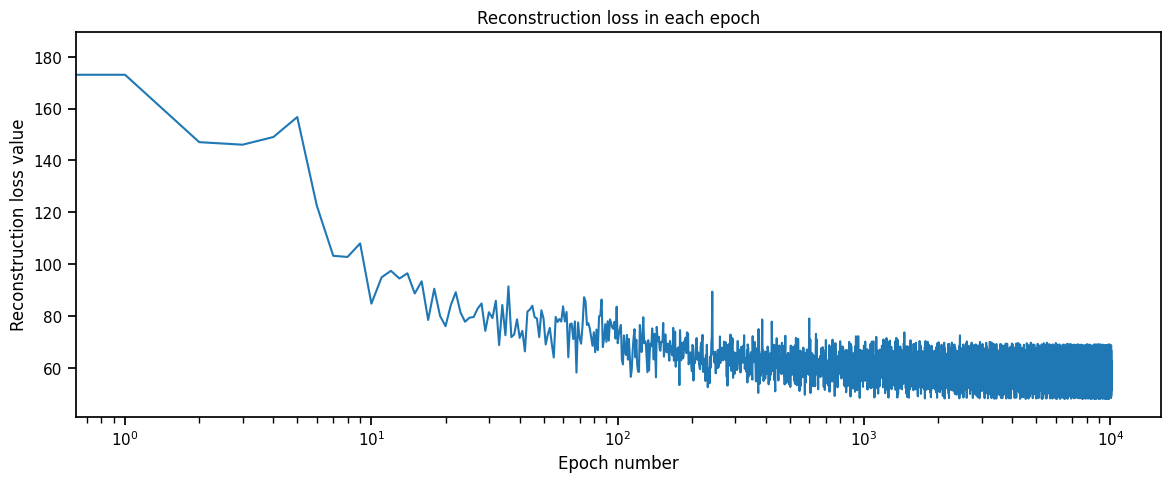

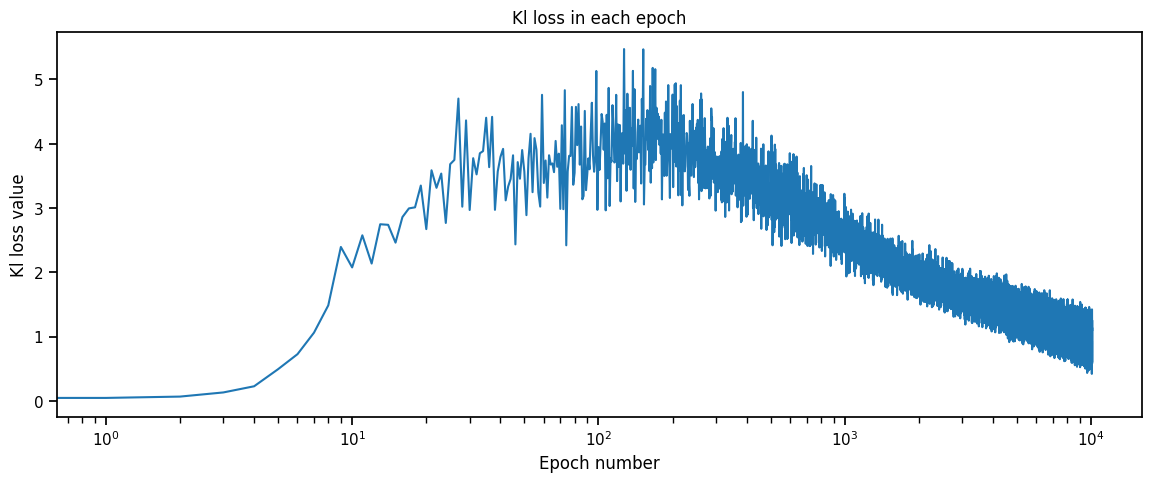

In [44]:
print_loss(total_loss, "Total")
print_loss(reconstruction_loss, "Reconstruction")
print_loss(kl_loss, "Kl")

In [105]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [106]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [112]:
a4_dims = (14, 5)

def print_loss(loss_values, loss_str):
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")

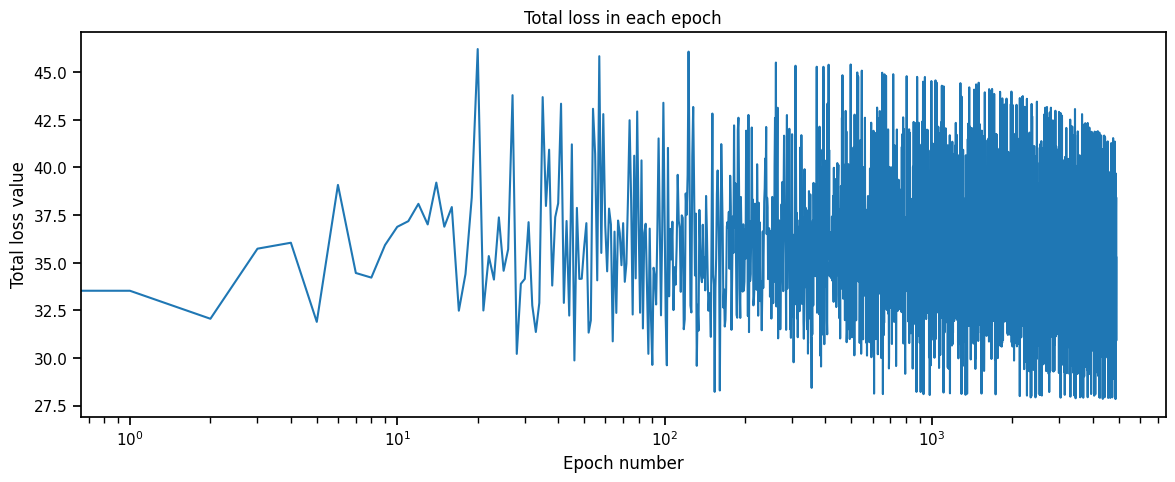

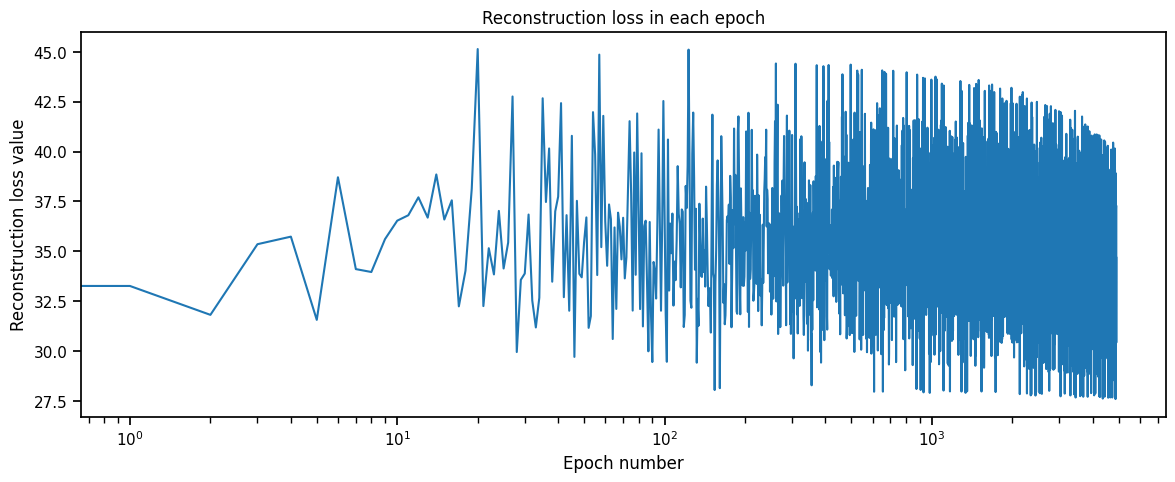

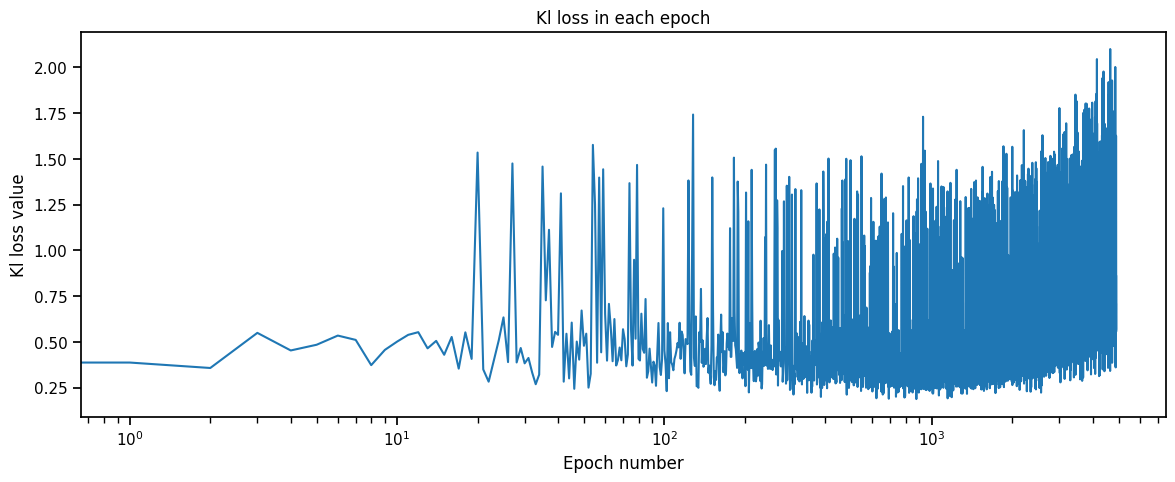

In [113]:
print_loss(total_loss[::10], "Total")
print_loss(reconstruction_loss[::10], "Reconstruction")
print_loss(kl_loss[::10], "Kl")